In [41]:
# Import packages

import pandas as pd
pd.set_option('display.max_columns', None)
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
import requests
import io

auth = ('FDS_DEMO_EUR_464603_SERVICES', '6hc85SGcgWCrkbJo')

In [42]:
## Define the names of factors that you are interested and enter their corresponding screening formulas

qfl_data = pd.read_excel('QFL.xlsx', header = 1)

qfl_data = qfl_data.drop(['Unnamed: 0'], axis = 1)

qfl_data.head()

,Factor Group,Field ID,Field Name,FactSet Screening Formula,Data Source,Unnamed: 6,Currency,Shares,CACCESS,Search Keywords,Data Type,String Length
0,Asset Data,DAYS_SINCE_RPT,Days Since Report,QFL_DAYS_SINCE_RPT(0),FactSet Estimates,"'Days Since Report': 'QFL_DAYS_SINCE_RPT(0)',",None,0,00QFL,"asset,data,estimates",INTEGER,NaN
1,Asset Data,DAYS_TO_RPT,Days to Report,QFL_DAYS_TO_RPT(0),FactSet Estimates,"'Days to Report': 'QFL_DAYS_TO_RPT(0)',",None,0,00QFL,"asset,data,estimates",INTEGER,NaN
2,Asset Data,ADR_FLAG,ADR Flag,QFL_ADR_FLAG(0),FactSet Reference Data,"'ADR Flag': 'QFL_ADR_FLAG(0)',",None,0,00QFL,"asset,reference,data",INTEGER,NaN
3,Asset Data,BANKRUPTCY,Bankruptcy Flag,QFL_BANKRUPTCY(0),FactSet Reference Data,"'Bankruptcy Flag': 'QFL_BANKRUPTCY(0)',",None,0,00QFL,"asset,reference,data",INTEGER,NaN
4,Asset Data,PRIMARY_LIST,Primary Listing,QFL_PRIMARY_LIST(0),FactSet Reference Data,"'Primary Listing': 'QFL_PRIMARY_LIST(0)',",None,0,00QFL,"asset,reference,data",INTEGER,NaN


In [43]:
# create QFL factor categories dictionary: Key = Field Name, Values = FactSet Screening Formula

qfl_categories = qfl_data['Factor Group'].unique()
qfl_categories = list(np.delete(qfl_categories, [0,1,2]))

for i in qfl_categories:
    globals()['qfl_{0}'.format(i).lower()] = dict(qfl_data[qfl_data['Factor Group'] == i][['FactSet Screening Formula', 'FactSet Screening Formula']].values)

qfl_categories

['Size',
 'Value',
 'Growth',
 'Profitability',
 'Efficiency',
 'Solvency',
 'Management',
 'Quality',
 'Analyst Sentiment',
 'Crowding',
 'Insider Activity',
 'Corporate Governance',
 'Momentum',
 'Volatility',
 'Market Sensitivity',
 'Technical',
 'Liquidity']

In [44]:
qfl_factors = globals()['qfl_{0}'.format('Analyst Sentiment').lower()] # change QFL Category here!

formulas = list(qfl_factors.values())
columns = list(qfl_factors.keys())

In [45]:
# Define Universe & QFL parameters

endpoint = "https://datadirect.factset.com/services/FastFetch?"
factlet = "ExtractBenchmarkDetail"

ids = "890100"
date = "11/30/2020"
fwd_date = "12/31/2020"

# Forward Returns, Size Class, Security Market Value (USD)

params = ['P_TOTAL_RETURN(' + str(date) + ',' + str(fwd_date) + ')',
          'QFL_SIZE_CLASS(' + str(date) + ')',
          'QFL_MKT_VAL_SEC(' + str(date) + ')']

items = 'PROPER_NAME, FG_GICS_SECTOR, PROPER(FG_COUNTRY)'

items_call = items + ',' + ','.join([str(elem) for elem in params]) + ',' + ','.join([str(qfl_elem) for qfl_elem in list(qfl_factors.values())])

# cutoff = "10"
output_format = "pipe"
showTitle = "N"
showHeader = "N"
showDataType = "N"

response = requests.post(endpoint, auth=auth, data = {'factlet':factlet, 
                                                      'ids':ids, 
                                                      'items': items_call,
                                                      'dates':date, 
                                                      # 'cutoff':cutoff,
                                                      'format':output_format,
                                                      'showTitle':showTitle,
                                                      'showHeader':showHeader,
                                                      'showDataType':showDataType})

df = pd.read_csv(io.StringIO(response.text), sep = '|')

In [58]:
col_universe = ['BENCHMARK_ID', 'DATE', 'SECURITY_ID', 'Weight', 'proper_name',
       'fg_gics_sector', 'proper', 'p_total_return', 'qfl_size_class', 'qfl_mkt_val_sec']
items_call_pipe = '|'.join([str(qfl_elem) for qfl_elem in list(qfl_factors.values())])
columns_name = col_universe + items_call_pipe.split('|')
df.columns = pd.Index(columns_name)

In [59]:
qfl_df = df

In [60]:
qfl_df.head()

,BENCHMARK_ID,DATE,SECURITY_ID,Weight,proper_name,fg_gics_sector,proper,p_total_return,qfl_size_class,qfl_mkt_val_sec,"QFL_SALES_EST_REV(0,45D)","QFL_SALES_EST_REV(0,75D)","QFL_SALES_EST_REV(0,100D)","QFL_SALES_EST_REV(0,180D)","QFL_OCF_EST_REV(0,45D)","QFL_OCF_EST_REV(0,75D)","QFL_OCF_EST_REV(0,100D)","QFL_OCF_EST_REV(0,180D)","QFL_FCF_EST_REV(0,45D)","QFL_FCF_EST_REV(0,75D)","QFL_FCF_EST_REV(0,100D)","QFL_FCF_EST_REV(0,180D)","QFL_EBIT_EST_REV(0,45D)","QFL_EBIT_EST_REV(0,75D)","QFL_EBIT_EST_REV(0,100D)","QFL_EBIT_EST_REV(0,180D)","QFL_EBITDA_EST_REV(0,45D)","QFL_EBITDA_EST_REV(0,75D)","QFL_EBITDA_EST_REV(0,100D)","QFL_EBITDA_EST_REV(0,180D)","QFL_EPS_EST_REV(0,45D)","QFL_EPS_EST_REV(0,75D)","QFL_EPS_EST_REV(0,100D)","QFL_EPS_EST_REV(0,180D)","QFL_PTGT_EST_REV(0,45D)","QFL_PTGT_EST_REV(0,75D)","QFL_PTGT_EST_REV(0,100D)","QFL_PTGT_EST_REV(0,180D)",QFL_SALES_STABLE_EST(0),QFL_OCF_STABLE_EST(0),QFL_FCF_STABLE_EST(0),QFL_EBIT_STABLE_EST(0),QFL_EBITDA_STABLE_EST(0),QFL_EPS_STABLE_EST(0),QFL_PTGT_STABLE_EST(0),QFL_SAPT(0),"QFL_ROBUST_EST_REV(0,45D)","QFL_ROBUST_EST_REV(0,75D)","QFL_ROBUST_EST_REV(0,100D)","QFL_ROBUST_EST_REV(0,180D)",QFL_ROBUST_EST_ITEM(0)
0,890100,30-Nov-2020,03783310,4.204100,Apple Inc.,Information Technology,United States,11.457372,Mega Cap,2024064.4,20.00000,16.666668,26.666668,26.666668,-30.000002,-30.000002,-20.000000,-20.000000,-20.000000,-20.000000,-10.000000,0.000000,3.846154,3.846154,11.538462,15.384616,16.666668,16.666668,16.666668,33.333336,8.823529,8.823529,11.764706,11.764706,24.324326,43.243244,70.270270,86.486490,32.706590,4.564552,4.542493,19.244207,19.508547,19.488585,6.180736,0.368052,0.071429,0.071429,0.107143,0.107143,NET_INC
1,890100,30-Nov-2020,59491810,3.141281,Microsoft Corporation,Information Technology,United States,3.900588,Mega Cap,1618475.4,-25.00000,-25.000000,-25.000000,-41.666664,0.000000,0.000000,0.000000,0.000000,40.000000,50.000000,50.000000,50.000000,20.833332,25.000000,25.000000,33.333336,50.000000,50.000000,50.000000,50.000000,39.285713,39.285713,39.285713,50.000000,51.724136,65.517240,68.965515,86.206894,109.112440,4.214087,2.703884,31.855938,14.435187,30.917423,21.198725,2.594193,0.500000,0.500000,0.500000,0.500000,EBITDA
2,890100,30-Nov-2020,02313510,2.735749,"Amazon.com, Inc.",Consumer Discretionary,United States,2.805829,Mega Cap,1589567.8,92.68293,92.682930,92.682930,92.682930,0.000000,0.000000,14.285715,14.285715,-22.222223,-22.222223,-22.222223,-22.222223,-74.285710,-71.428570,-71.428570,-74.285710,-61.290325,-61.290325,-61.290325,-58.064514,-74.418600,-74.418600,-74.418600,-74.418600,50.000000,56.521736,58.695650,86.956520,64.491000,3.658377,1.738355,4.552811,12.300735,4.968252,15.317146,2.648956,-0.677419,-0.677419,-0.677419,-0.645161,EBITDA_ADJ
3,890100,30-Nov-2020,30303M10,1.356526,"Facebook, Inc. Class A",Communication Services,United States,-1.375598,Mega Cap,665827.3,92.50000,92.500000,92.500000,92.500000,87.500000,87.500000,87.500000,87.500000,0.000000,0.000000,0.000000,0.000000,91.666670,91.666670,94.444440,94.444440,91.666670,91.666670,91.666670,91.666670,88.636360,88.636360,90.909096,93.181816,79.069770,83.720930,86.046510,93.023260,40.165850,7.576492,4.861445,14.970654,28.221222,13.357665,16.782465,2.464546,1.000000,1.000000,1.000000,1.000000,BPS
4,890100,30-Nov-2020,02079K10,1.085045,Alphabet Inc. Class C,Communication Services,United States,-0.503194,Mega Cap,580810.4,92.30769,92.307690,92.307690,92.307690,0.000000,0.000000,0.000000,0.000000,50.000000,50.000000,50.000000,50.000000,80.000000,80.000000,80.000000,76.666664,90.476190,90.476190,90.476190,90.476190,73.529410,76.470590,76.470590,73.529410,92.105260,92.105260,94.736850,94.736850,34.794197,21.309880,5.774197,9.747973,18.677095,9.354807,13.001797,1.099191,0.904762,0.904762,0.904762,0.904762,EBITDA


In [61]:
qfl_df.tail()

,BENCHMARK_ID,DATE,SECURITY_ID,Weight,proper_name,fg_gics_sector,proper,p_total_return,qfl_size_class,qfl_mkt_val_sec,"QFL_SALES_EST_REV(0,45D)","QFL_SALES_EST_REV(0,75D)","QFL_SALES_EST_REV(0,100D)","QFL_SALES_EST_REV(0,180D)","QFL_OCF_EST_REV(0,45D)","QFL_OCF_EST_REV(0,75D)","QFL_OCF_EST_REV(0,100D)","QFL_OCF_EST_REV(0,180D)","QFL_FCF_EST_REV(0,45D)","QFL_FCF_EST_REV(0,75D)","QFL_FCF_EST_REV(0,100D)","QFL_FCF_EST_REV(0,180D)","QFL_EBIT_EST_REV(0,45D)","QFL_EBIT_EST_REV(0,75D)","QFL_EBIT_EST_REV(0,100D)","QFL_EBIT_EST_REV(0,180D)","QFL_EBITDA_EST_REV(0,45D)","QFL_EBITDA_EST_REV(0,75D)","QFL_EBITDA_EST_REV(0,100D)","QFL_EBITDA_EST_REV(0,180D)","QFL_EPS_EST_REV(0,45D)","QFL_EPS_EST_REV(0,75D)","QFL_EPS_EST_REV(0,100D)","QFL_EPS_EST_REV(0,180D)","QFL_PTGT_EST_REV(0,45D)","QFL_PTGT_EST_REV(0,75D)","QFL_PTGT_EST_REV(0,100D)","QFL_PTGT_EST_REV(0,180D)",QFL_SALES_STABLE_EST(0),QFL_OCF_STABLE_EST(0),QFL_FCF_STABLE_EST(0),QFL_EBIT_STABLE_EST(0),QFL_EBITDA_STABLE_EST(0),QFL_EPS_STABLE_EST(0),QFL_PTGT_STABLE_EST(0),QFL_SAPT(0),"QFL_ROBUST_EST_REV(0,45D)","QFL_ROBUST_EST_REV(0,75D)","QFL_ROBUST_EST_REV(0,100D)","QFL_ROBUST_EST_REV(0,180D)",QFL_ROBUST_EST_ITEM(0)
1595,890100,30-Nov-2020,BZ22BK,0.002738,SmartCentres Real Estate Investment Trust,Real Estate,Canada,-3.552645,Mid Cap,2688.3582,-50.0,0.000000,0.000000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,66.66667,33.333336,33.333336,33.333336,0.00000,-100.000000,-100.000000,-100.000000,75.0,75.000000,75.000000,62.500000,36.734770,NaN,NaN,NaN,8.440292,NaN,5.164942,0.502705,0.0,0.0,0.0,0.0,FFO
1596,890100,30-Nov-2020,B2NT8S,0.002637,"Seven Bank, Ltd.",Financials,Japan,-4.803491,Mid Cap,2619.2988,50.0,50.000000,50.000000,50.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,-100.0,-100.0,NaN,NaN,NaN,NaN,100.00000,100.000000,100.000000,100.000000,-25.0,-25.000000,-75.000000,-75.000000,38.083748,NaN,NaN,NaN,NaN,25.502640,3.575890,0.585734,NaN,NaN,NaN,NaN,NaN
1597,890100,30-Nov-2020,BKSLS5,0.002617,First Capital Real Estate Investment Trust,Real Estate,Canada,-12.513375,Mid Cap,2634.8494,0.0,0.000000,0.000000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.00000,0.000000,0.000000,0.000000,0.00000,-100.000000,-100.000000,-100.000000,0.0,0.000000,0.000000,0.000000,93.035965,NaN,NaN,NaN,35.904945,NaN,4.569120,0.569213,0.2,0.2,0.2,0.2,FFO
1598,890100,30-Nov-2020,659844,0.002463,Mitsubishi Motors Corporation,Consumer Discretionary,Japan,15.425528,Mid Cap,2808.4746,0.0,16.666668,16.666668,16.666668,100.0,100.0,100.00000,100.00000,-100.0,-100.0,-100.0,-100.0,0.0,0.0,0.0,0.0,-50.00000,-100.000000,-100.000000,-100.000000,66.66667,33.333336,33.333336,33.333336,-25.0,-41.666664,-58.333332,-75.000000,9.004589,-0.693377,-2.272224,-1.744070,-0.642571,-2.022806,3.564689,0.561770,0.5,0.5,0.5,0.5,PTX_INC_REP
1599,890100,30-Nov-2020,656950,0.002419,Maruichi Steel Tube Ltd.,Materials,Japan,4.007292,Small Cap,2063.3816,0.0,0.000000,-100.000000,-100.000000,0.0,0.0,66.66667,66.66667,0.0,0.0,50.0,50.0,0.0,0.0,-50.0,-50.0,0.00000,0.000000,0.000000,0.000000,0.00000,0.000000,66.666670,33.333336,0.0,0.000000,33.333336,33.333336,27.934309,3.294330,0.379622,5.068406,34.463997,4.948274,5.194523,1.232687,0.0,0.0,-0.5,-0.5,PTX_INC


In [50]:
# Summary Stats

qfl_df.describe()

,BENCHMARK_ID,Weight,p_total_return,qfl_mkt_val_sec,"QFL_SALES_EST_REV(0,45D)","QFL_SALES_EST_REV(0,75D)","QFL_SALES_EST_REV(0,100D)","QFL_SALES_EST_REV(0,180D)","QFL_OCF_EST_REV(0,45D)","QFL_OCF_EST_REV(0,75D)","QFL_OCF_EST_REV(0,100D)","QFL_OCF_EST_REV(0,180D)","QFL_FCF_EST_REV(0,45D)","QFL_FCF_EST_REV(0,75D)","QFL_FCF_EST_REV(0,100D)","QFL_FCF_EST_REV(0,180D)","QFL_EBIT_EST_REV(0,45D)","QFL_EBIT_EST_REV(0,75D)","QFL_EBIT_EST_REV(0,100D)","QFL_EBIT_EST_REV(0,180D)","QFL_EBITDA_EST_REV(0,45D)","QFL_EBITDA_EST_REV(0,75D)","QFL_EBITDA_EST_REV(0,100D)","QFL_EBITDA_EST_REV(0,180D)","QFL_EPS_EST_REV(0,45D)","QFL_EPS_EST_REV(0,75D)","QFL_EPS_EST_REV(0,100D)","QFL_EPS_EST_REV(0,180D)","QFL_PTGT_EST_REV(0,45D)","QFL_PTGT_EST_REV(0,75D)","QFL_PTGT_EST_REV(0,100D)","QFL_PTGT_EST_REV(0,180D)",QFL_SALES_STABLE_EST(0),QFL_OCF_STABLE_EST(0),QFL_FCF_STABLE_EST(0),QFL_EBIT_STABLE_EST(0),QFL_EBITDA_STABLE_EST(0),QFL_EPS_STABLE_EST(0),QFL_PTGT_STABLE_EST(0),QFL_SAPT(0),"QFL_ROBUST_EST_REV(0,45D)","QFL_ROBUST_EST_REV(0,75D)","QFL_ROBUST_EST_REV(0,100D)","QFL_ROBUST_EST_REV(0,180D)"
count,1600.0,1600.000000,1597.000000,1.598000e+03,1589.000000,1589.000000,1589.000000,1589.000000,1339.000000,1339.000000,1339.000000,1339.000000,1388.000000,1388.000000,1388.000000,1388.000000,1586.000000,1586.000000,1586.000000,1586.000000,1470.000000,1470.000000,1470.000000,1470.000000,1594.000000,1594.000000,1594.000000,1594.000000,1595.000000,1595.000000,1595.000000,1595.000000,1570.000000,1280.000000,1285.000000,1559.000000,1399.000000,1584.000000,1590.000000,1590.000000,1309.000000,1309.000000,1309.000000,1309.000000
mean,890100.0,0.062500,3.118575,3.489420e+04,9.297955,10.917017,11.251604,10.378199,2.334093,3.225345,2.369365,1.737796,3.056753,3.531713,2.753156,2.425689,9.250532,9.897336,10.168902,9.185374,11.643451,12.303029,12.216441,11.429230,9.753864,9.952821,10.133578,9.401488,27.901942,33.480176,36.395424,40.579090,71.949236,7.520192,4.123841,18.349288,20.972182,16.119324,8.746710,0.530233,0.063591,0.066513,0.071061,0.061786
std,0.0,0.177252,7.256757,9.150908e+04,50.671275,55.997514,59.254316,62.222702,53.252384,57.256526,60.549081,62.436146,58.351730,62.171857,64.876021,66.346593,53.396509,57.546106,60.506825,62.276041,55.178990,59.196634,62.768672,65.242030,56.486887,61.081853,63.423523,65.326967,37.785160,42.835938,45.937630,48.604178,670.972539,24.338244,14.574088,88.984459,26.753157,49.872483,9.927649,0.942127,0.559197,0.604402,0.624865,0.644109
min,890100.0,0.002419,-31.602722,2.063382e+03,-100.000000,-100.000000,-100.000000,-100.000000,-100.000000,-100.000000,-100.000000,-100.000000,-100.000000,-100.000000,-100.000000,-100.000000,-100.000000,-100.000000,-100.000000,-100.000000,-100.000000,-100.000000,-100.000000,-100.000000,-100.000000,-100.000000,-100.000000,-100.000000,-100.000000,-100.000000,-100.000000,-100.000000,0.332838,-17.179830,-26.773338,-17.359950,-13.698847,-21.134930,1.288655,-3.445105,-1.000000,-1.000000,-1.000000,-1.000000
25%,890100.0,0.012927,-1.169592,8.494103e+03,-16.666668,-25.000000,-33.333336,-37.500000,-25.000000,-33.333336,-37.980770,-42.857143,-33.333336,-40.000000,-50.000000,-50.000000,-25.000000,-30.000002,-33.333336,-34.294874,-20.000000,-27.272728,-33.333336,-36.363636,-25.000000,-32.954547,-33.333336,-38.461540,0.000000,0.000000,0.000000,6.666667,14.162370,1.825753,0.618807,3.891466,6.861093,3.005028,5.590191,-0.036170,-0.285714,-0.333333,-0.333333,-0.400000
50%,890100.0,0.024960,2.384615,1.491753e+04,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,7.179488,0.000000,0.000000,6.666667,5.000000,28.000000,38.095238,42.857143,52.173912,29.844132,3.871748,1.958332,9.113464,14.073868,8.091404,7.631030,0.472402,0.000000,0.000000,0.000000,0.000000
75%,890100.0,0.057592,6.821418,3.202311e+04,45.454548,50.000000,60.000004,66.666670,33.333336,40.000000,50.000000,50.000000,40.000000,50.000000,50.000000,50.00

In [54]:
# Check NAs

qfl_df.isna().sum()

BENCHMARK_ID                    0
DATE                            0
SECURITY_ID                     0
Weight                          0
proper_name                     0
fg_gics_sector                  2
proper                          0
p_total_return                  3
qfl_size_class                  2
qfl_mkt_val_sec                 2
QFL_SALES_EST_REV(0,45D)       11
QFL_SALES_EST_REV(0,75D)       11
QFL_SALES_EST_REV(0,100D)      11
QFL_SALES_EST_REV(0,180D)      11
QFL_OCF_EST_REV(0,45D)        261
QFL_OCF_EST_REV(0,75D)        261
QFL_OCF_EST_REV(0,100D)       261
QFL_OCF_EST_REV(0,180D)       261
QFL_FCF_EST_REV(0,45D)        212
QFL_FCF_EST_REV(0,75D)        212
QFL_FCF_EST_REV(0,100D)       212
QFL_FCF_EST_REV(0,180D)       212
QFL_EBIT_EST_REV(0,45D)        14
QFL_EBIT_EST_REV(0,75D)        14
QFL_EBIT_EST_REV(0,100D)       14
QFL_EBIT_EST_REV(0,180D)       14
QFL_EBITDA_EST_REV(0,45D)     130
QFL_EBITDA_EST_REV(0,75D)     130
QFL_EBITDA_EST_REV(0,100D)    130
QFL_EBITDA_EST

In [79]:
# Filter for float/numeric parameters only

filter_idx = [idx for idx, col in enumerate(qfl_df.columns) if qfl_df[col].values.dtype != 'O' if idx > 9 and qfl_df[col].count() > 0 and qfl_df[col].sum() > 0 and qfl_df[col].values.dtype == 'float64']

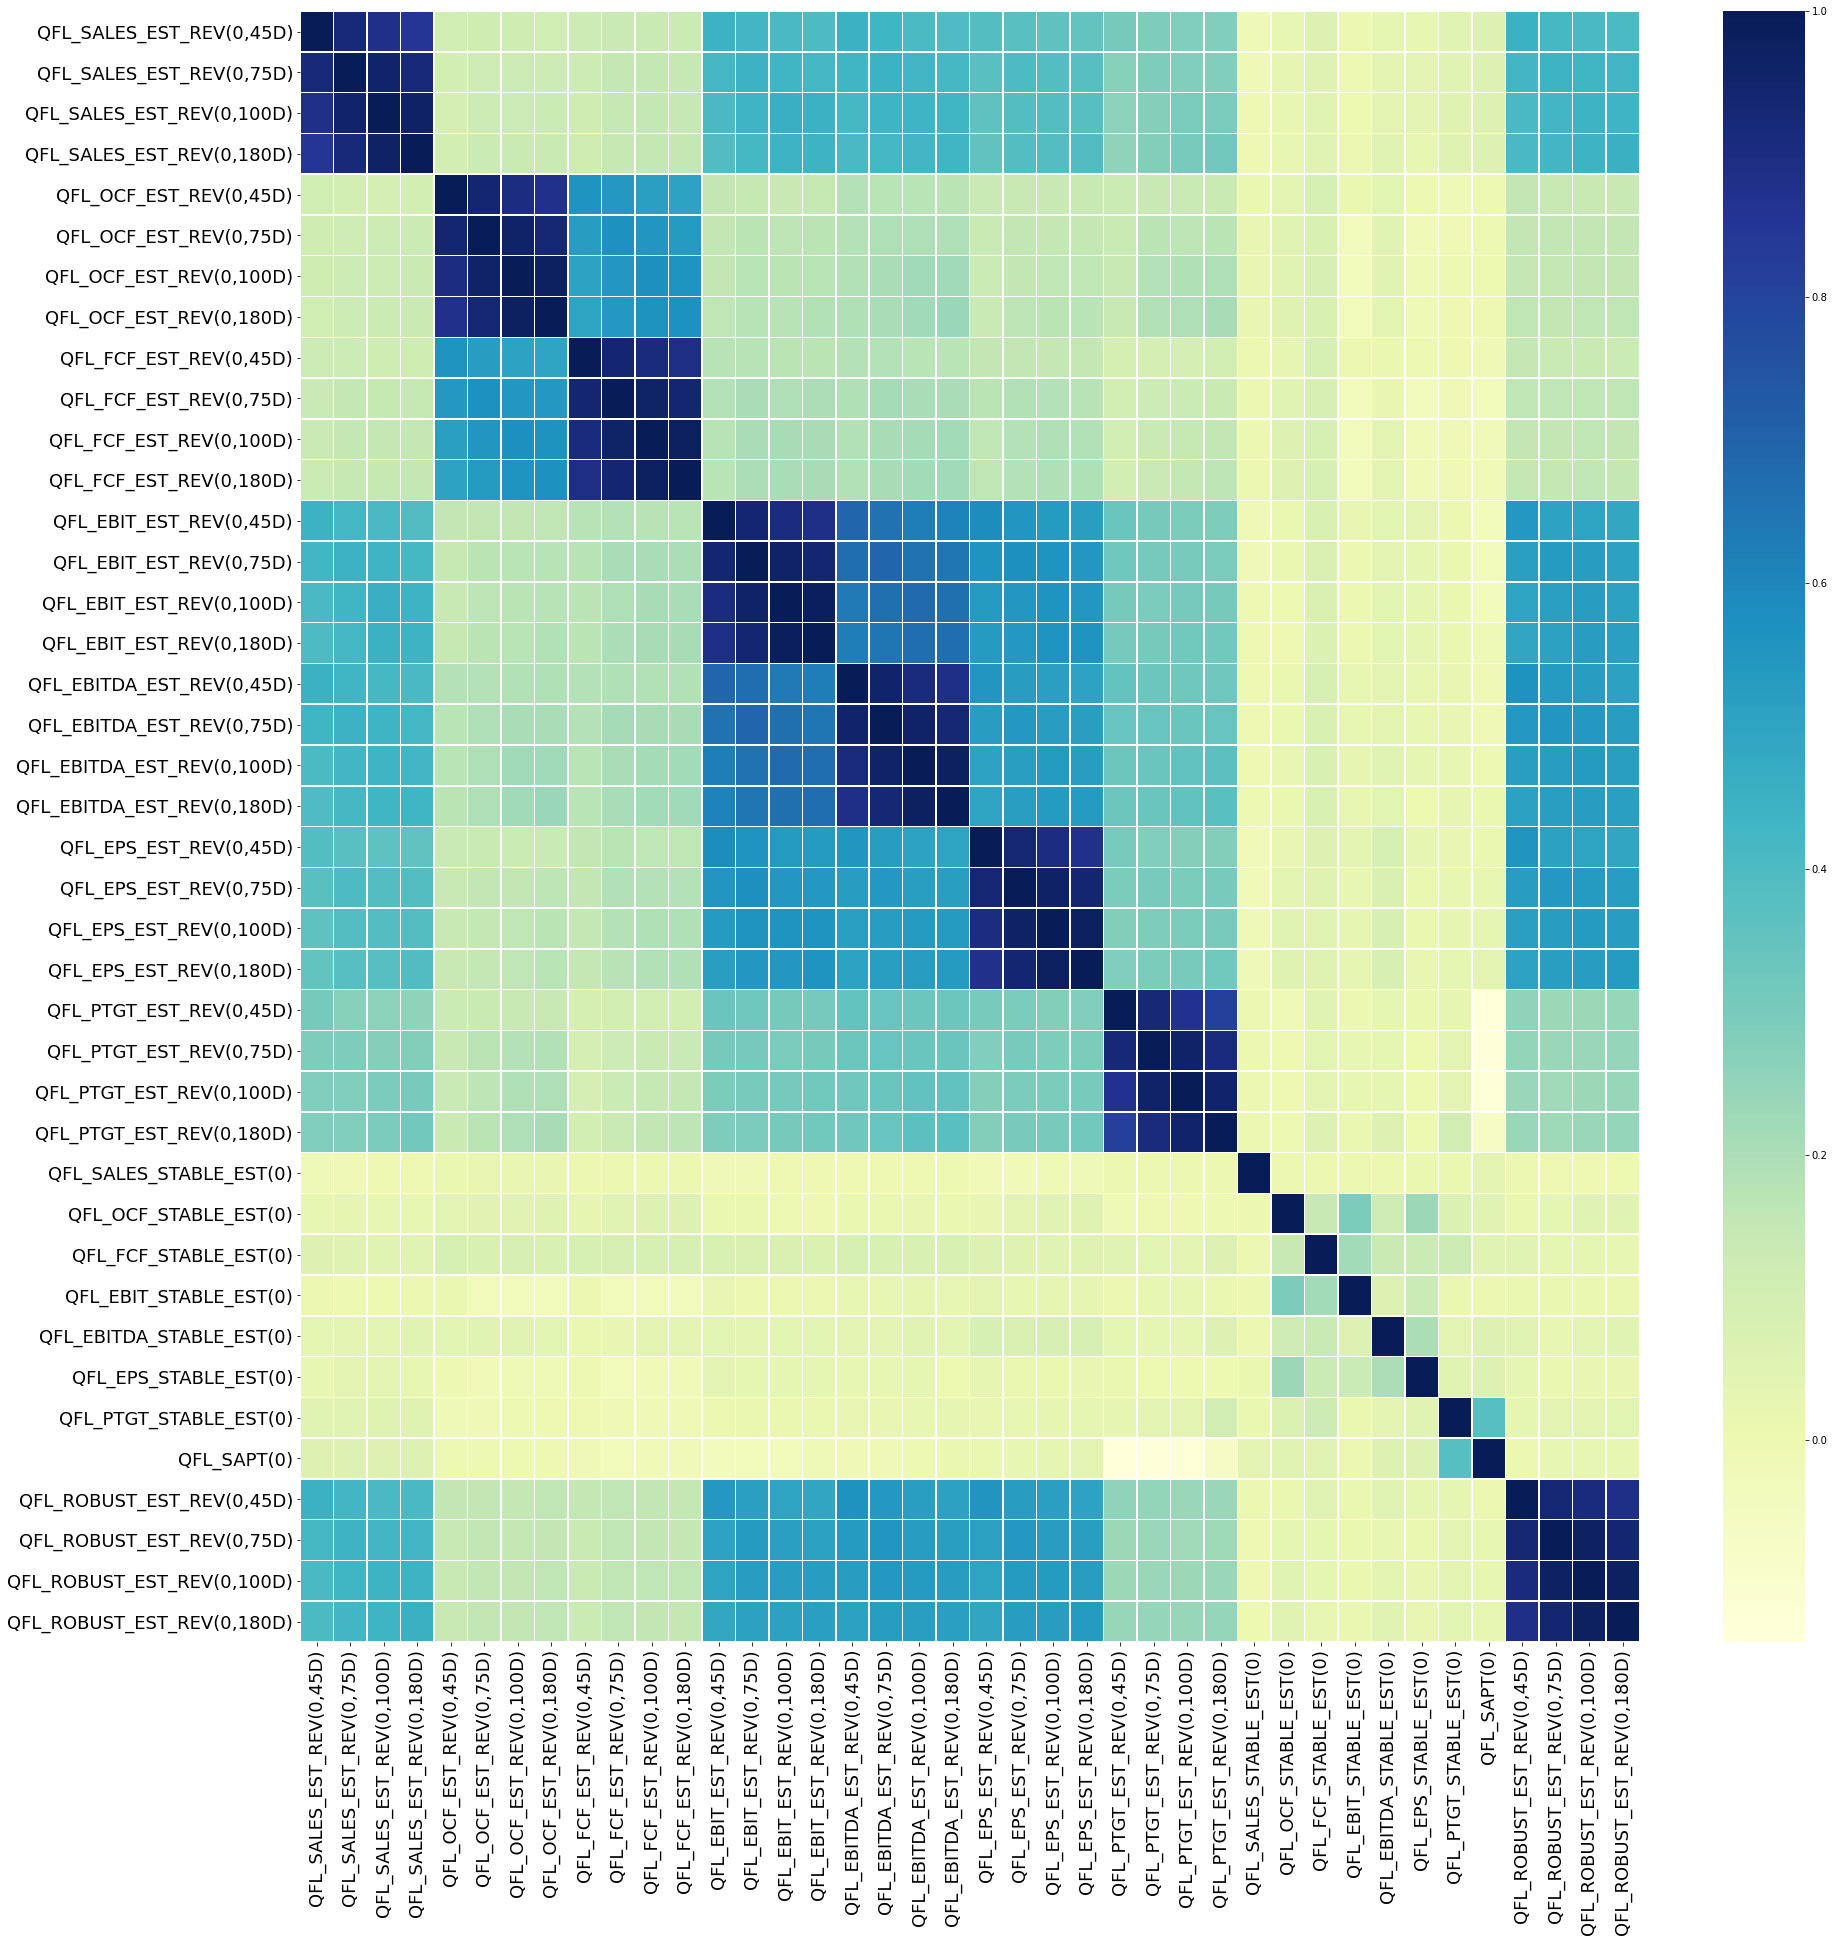

In [80]:
## Plot the correlation between each pair of factors

fig, ax = plt.subplots(figsize=(30,30))
hm = sns.heatmap(qfl_df[[c for c in qfl_df.columns[filter_idx]]].corr(), cmap="YlGnBu", annot = False, linewidths=.5, ax = ax)
hm.set_yticklabels(hm.get_ymajorticklabels(), fontsize = 18, rotation=0)
hm.set_xticklabels(hm.get_xmajorticklabels(), fontsize = 18, rotation=90)
plt.show()

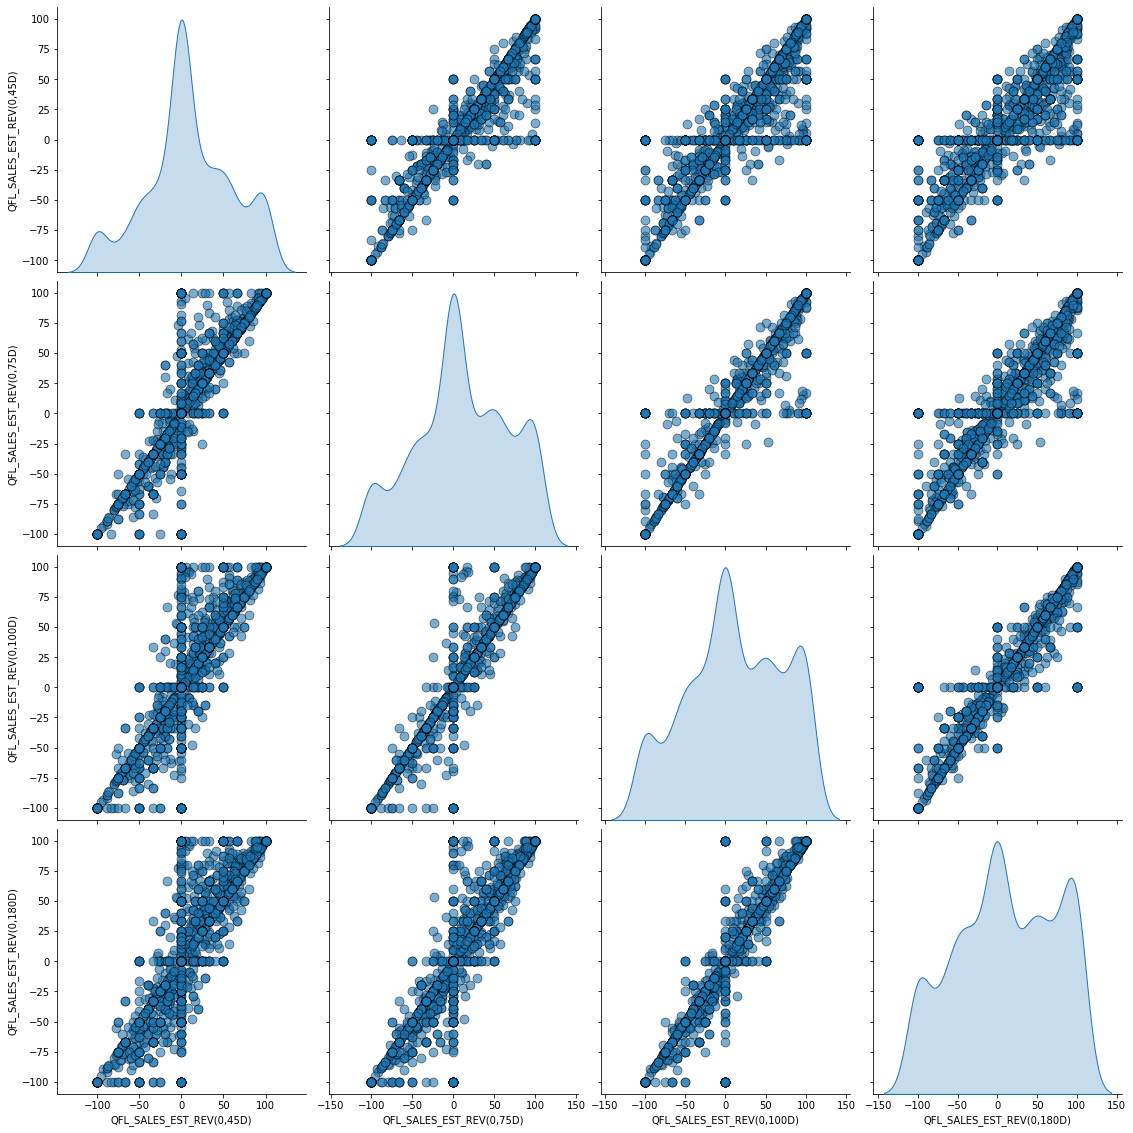

In [81]:
# Pairplot

sns.pairplot(qfl_df[qfl_df.columns[filter_idx[:4]].values], diag_kind = 'kde',
             plot_kws = {'alpha': 0.6, 's': 80, 'edgecolor': 'k'}, height = 4);
#plt.show()

In [82]:
qfl_df[qfl_df.columns[filter_idx[:4]].values]

,"QFL_SALES_EST_REV(0,45D)","QFL_SALES_EST_REV(0,75D)","QFL_SALES_EST_REV(0,100D)","QFL_SALES_EST_REV(0,180D)"
0,20.00000,16.666668,26.666668,26.666668
1,-25.00000,-25.000000,-25.000000,-41.666664
2,92.68293,92.682930,92.682930,92.682930
3,92.50000,92.500000,92.500000,92.500000
4,92.30769,92.307690,92.307690,92.307690
...,...,...,...,...
1595,-50.00000,0.000000,0.000000,0.000000
1596,50.00000,50.000000,50.000000,50.000000
1597,0.00000,0.000000,0.000000,0.000000
1598,0.00000,16.666668,16.666668,16.666668


In [83]:
# Other Statistics

advanced_describe = {}
stats_table = pd.DataFrame()
for factor in list(qfl_df.columns[filter_idx].values):
    advanced_describe[factor] = stats.describe(qfl_df[factor].dropna(), axis=0)    
    adv_stats = {keys: [np.round(series, 2) for series in values] for (keys, values) in zip(advanced_describe.keys(), advanced_describe.values())}
    stats_table = pd.DataFrame(adv_stats, index=['nobs', 'minmax', 'mean', 'variance', 'skewness', 'kurtosis']).T
stats_table

,nobs,minmax,mean,variance,skewness,kurtosis
"QFL_SALES_EST_REV(0,45D)",1589,"[-100.0, 100.0]",9.3,2567.58,-0.1,-0.31
"QFL_SALES_EST_REV(0,75D)",1589,"[-100.0, 100.0]",10.92,3135.72,-0.15,-0.71
"QFL_SALES_EST_REV(0,100D)",1589,"[-100.0, 100.0]",11.25,3511.07,-0.17,-0.9
"QFL_SALES_EST_REV(0,180D)",1589,"[-100.0, 100.0]",10.38,3871.66,-0.16,-1.05
"QFL_OCF_EST_REV(0,45D)",1339,"[-100.0, 100.0]",2.33,2835.82,-0.11,-0.29
"QFL_OCF_EST_REV(0,75D)",1339,"[-100.0, 100.0]",3.23,3278.31,-0.1,-0.58
"QFL_OCF_EST_REV(0,100D)",1339,"[-100.0, 100.0]",2.37,3666.19,-0.08,-0.83
"QFL_OCF_EST_REV(0,180D)",1339,"[-100.0, 100.0]",1.74,3898.27,-0.07,-0.93
"QFL_FCF_EST_REV(0,45D)",1388,"[-100.0, 100.0]",3.06,3404.92,-0.07,-0.62
"QFL_FCF_EST_REV(0,75D)",1388,"[-100.0, 100.0]",3.53,3865.34,-0.1,-0.86


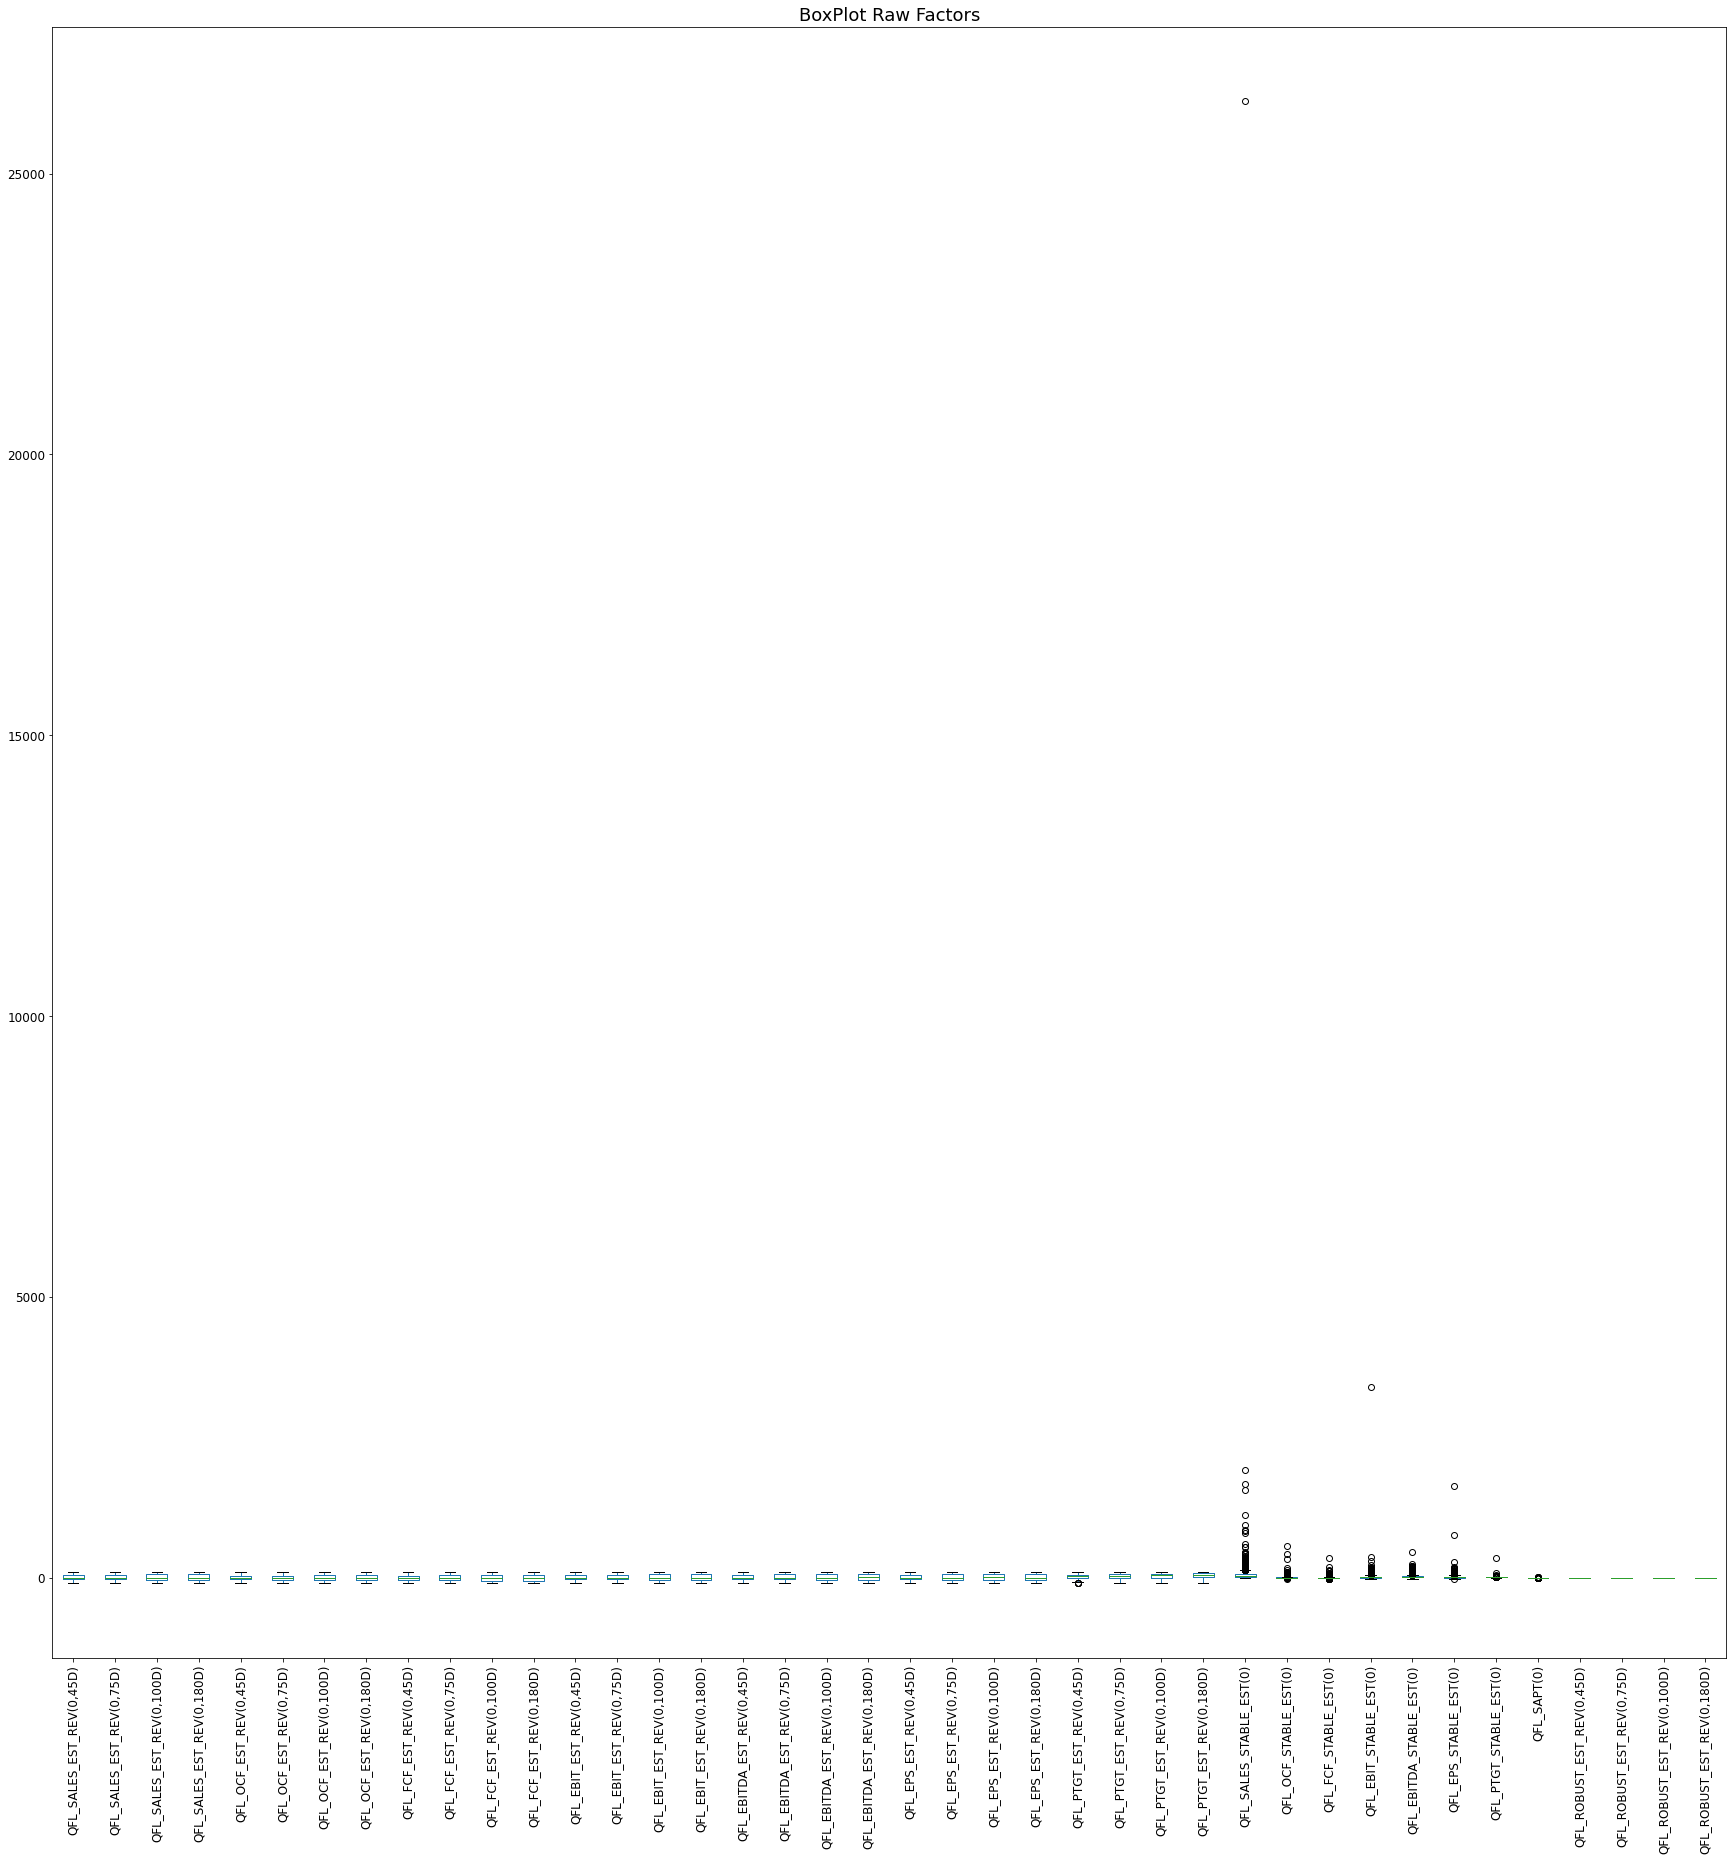

In [84]:
# Box-Whisker plot

qfl_df[qfl_df.columns[filter_idx]].boxplot(grid=False, rot=90, fontsize=12, figsize = (30,30)).set_title('BoxPlot Raw Factors', fontsize = 18);

In [85]:
# Z-Score

qfl_df_z = pd.DataFrame()

for factor in qfl_df[qfl_df.columns[filter_idx]]:
    z_score = ( qfl_df[factor] - qfl_df[factor].mean() ) / qfl_df[factor].std()
    qfl_df_z[factor] = z_score

qfl_df_z.describe()

,"QFL_SALES_EST_REV(0,45D)","QFL_SALES_EST_REV(0,75D)","QFL_SALES_EST_REV(0,100D)","QFL_SALES_EST_REV(0,180D)","QFL_OCF_EST_REV(0,45D)","QFL_OCF_EST_REV(0,75D)","QFL_OCF_EST_REV(0,100D)","QFL_OCF_EST_REV(0,180D)","QFL_FCF_EST_REV(0,45D)","QFL_FCF_EST_REV(0,75D)","QFL_FCF_EST_REV(0,100D)","QFL_FCF_EST_REV(0,180D)","QFL_EBIT_EST_REV(0,45D)","QFL_EBIT_EST_REV(0,75D)","QFL_EBIT_EST_REV(0,100D)","QFL_EBIT_EST_REV(0,180D)","QFL_EBITDA_EST_REV(0,45D)","QFL_EBITDA_EST_REV(0,75D)","QFL_EBITDA_EST_REV(0,100D)","QFL_EBITDA_EST_REV(0,180D)","QFL_EPS_EST_REV(0,45D)","QFL_EPS_EST_REV(0,75D)","QFL_EPS_EST_REV(0,100D)","QFL_EPS_EST_REV(0,180D)","QFL_PTGT_EST_REV(0,45D)","QFL_PTGT_EST_REV(0,75D)","QFL_PTGT_EST_REV(0,100D)","QFL_PTGT_EST_REV(0,180D)",QFL_SALES_STABLE_EST(0),QFL_OCF_STABLE_EST(0),QFL_FCF_STABLE_EST(0),QFL_EBIT_STABLE_EST(0),QFL_EBITDA_STABLE_EST(0),QFL_EPS_STABLE_EST(0),QFL_PTGT_STABLE_EST(0),QFL_SAPT(0),"QFL_ROBUST_EST_REV(0,45D)","QFL_ROBUST_EST_REV(0,75D)","QFL_ROBUST_EST_REV(0,100D)","QFL_ROBUST_EST_REV(0,180D)"
count,1.589000e+03,1.589000e+03,1.589000e+03,1.589000e+03,1.339000e+03,1.339000e+03,1.339000e+03,1.339000e+03,1.388000e+03,1.388000e+03,1.388000e+03,1.388000e+03,1.586000e+03,1.586000e+03,1.586000e+03,1.586000e+03,1.470000e+03,1.470000e+03,1.470000e+03,1.470000e+03,1.594000e+03,1.594000e+03,1.594000e+03,1.594000e+03,1.595000e+03,1.595000e+03,1.595000e+03,1.595000e+03,1.570000e+03,1.280000e+03,1.285000e+03,1.559000e+03,1.399000e+03,1.584000e+03,1.590000e+03,1.590000e+03,1.309000e+03,1.309000e+03,1.309000e+03,1.309000e+03
mean,4.187965e-16,-2.174332e-16,-1.215726e-17,-7.038632e-16,3.233659e-18,-5.993152e-17,-2.172356e-17,-1.591955e-17,-3.017019e-17,4.564272e-17,2.310832e-16,2.046874e-16,9.243692e-17,-2.485052e-17,-6.760040e-16,-5.460113e-17,3.527979e-16,1.754832e-16,8.417303e-17,6.193081e-17,2.513151e-16,-9.912954e-17,5.801856e-17,1.049627e-16,-1.867611e-15,-2.475763e-15,-1.002133e-15,-5.324024e-16,1.434539e-16,2.470897e-16,1.639847e-16,-8.823389e-17,8.308817e-17,3.211692e-16,2.536057e-16,-2.311219e-17,7.667239e-17,-1.655263e-16,-1.242534e-16,-2.586845e-17
std,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
min,-2.157000e+00,-1.980749e+00,-1.877527e+00,-1.773922e+00,-1.921681e+00,-1.802857e+00,-1.690684e+00,-1.629470e+00,-1.766130e+00,-1.665250e+00,-1.583839e+00,-1.543797e+00,-2.046024e+00,-1.909727e+00,-1.820768e+00,-1.753248e+00,-2.023296e+00,-1.897118e+00,-1.787778e+00,-1.707936e+00,-1.942997e+00,-1.800090e+00,-1.736478e+00,-1.674676e+00,-3.384978e+00,-3.116079e+00,-2.969144e+00,-2.892325e+00,-1.067352e-01,-1.014865e+00,-2.120008e+00,-4.012975e-01,-1.295960e+00,-7.469902e-01,-7.512409e-01,-4.219537e+00,-1.901998e+00,-1.764577e+00,-1.714067e+00,-1.648458e+00
25%,-5.124131e-01,-6.414038e-01,-7.524336e-01,-7.694651e-01,-5.132933e-01,-6.385068e-01,-6.664038e-01,-7.142487e-01,-6.236334e-01,-7.001836e-01,-8.131380e-01,-7.901791e-01,-6.414377e-01,-6.933108e-01,-7.189641e-01,-6.981858e-01,-5.734692e-01,-6.685474e-01,-7.256769e-01,-7.325472e-01,-6.152554e-01,-7.024569e-01,-6.853437e-01,-7.326688e-01,-7.384365e-01,-7.815908e-01,-7.922791e-01,-6.977265e-01,-8.612404e-02,-2.339708e-01,-2.404977e-01,-1.624758e-01,-5.274551e-01,-2.629565e-01,-3.179523e-01,-6.011957e-01,-6.246557e-01,-6.615577e-01,-6.471700e-01,-7.169387e-01
50%,-1.834956e-01,-1.949554e-01,-1.898867e-01,-1.667912e-01,-4.383077e-02,-5.633148e-02,-3.913131e-02,-2.783317e-02,-5.238496e-02,-5.680565e-02,-4.243719e-02,-3.656087e-02,-1.732423e-01,-1.719897e-01,-1.680621e-01,-1.474945e-01,-2.110124e-01,-2.07

In [86]:
# look for "extremely large" column's values after normalization (Descending)

for col_z in qfl_df_z:
    qfl_df_z[col_z] = qfl_df_z[col_z].sort_values(ignore_index=True, ascending = False)
    
qfl_df_z

,"QFL_SALES_EST_REV(0,45D)","QFL_SALES_EST_REV(0,75D)","QFL_SALES_EST_REV(0,100D)","QFL_SALES_EST_REV(0,180D)","QFL_OCF_EST_REV(0,45D)","QFL_OCF_EST_REV(0,75D)","QFL_OCF_EST_REV(0,100D)","QFL_OCF_EST_REV(0,180D)","QFL_FCF_EST_REV(0,45D)","QFL_FCF_EST_REV(0,75D)","QFL_FCF_EST_REV(0,100D)","QFL_FCF_EST_REV(0,180D)","QFL_EBIT_EST_REV(0,45D)","QFL_EBIT_EST_REV(0,75D)","QFL_EBIT_EST_REV(0,100D)","QFL_EBIT_EST_REV(0,180D)","QFL_EBITDA_EST_REV(0,45D)","QFL_EBITDA_EST_REV(0,75D)","QFL_EBITDA_EST_REV(0,100D)","QFL_EBITDA_EST_REV(0,180D)","QFL_EPS_EST_REV(0,45D)","QFL_EPS_EST_REV(0,75D)","QFL_EPS_EST_REV(0,100D)","QFL_EPS_EST_REV(0,180D)","QFL_PTGT_EST_REV(0,45D)","QFL_PTGT_EST_REV(0,75D)","QFL_PTGT_EST_REV(0,100D)","QFL_PTGT_EST_REV(0,180D)",QFL_SALES_STABLE_EST(0),QFL_OCF_STABLE_EST(0),QFL_FCF_STABLE_EST(0),QFL_EBIT_STABLE_EST(0),QFL_EBITDA_STABLE_EST(0),QFL_EPS_STABLE_EST(0),QFL_PTGT_STABLE_EST(0),QFL_SAPT(0),"QFL_ROBUST_EST_REV(0,45D)","QFL_ROBUST_EST_REV(0,75D)","QFL_ROBUST_EST_REV(0,100D)","QFL_ROBUST_EST_REV(0,180D)"
0,1.790009,1.590838,1.497754,1.440339,1.834019,1.690194,1.612421,1.573803,1.66136,1.551639,1.498964,1.470676,1.699539,1.565747,1.484644,1.458259,1.601272,1.481452,1.398525,1.357572,1.597648,1.474205,1.416926,1.386847,1.908105,1.552898,1.384586,1.222547,39.083054,22.823083,23.564195,37.959958,16.421502,32.554256,35.173533,7.618653,1.674561,1.544481,1.486624,1.456607
1,1.790009,1.590838,1.497754,1.440339,1.834019,1.690194,1.612421,1.573803,1.66136,1.551639,1.498964,1.470676,1.699539,1.565747,1.484644,1.458259,1.601272,1.481452,1.398525,1.357572,1.597648,1.474205,1.416926,1.386847,1.908105,1.552898,1.384586,1.222547,2.750698,17.033426,12.810206,3.866878,8.304981,14.982564,7.778130,7.320832,1.674561,1.544481,1.486624,1.456607
2,1.790009,1.590838,1.497754,1.440339,1.834019,1.690194,1.612421,1.573803,1.66136,1.551639,1.498964,1.470676,1.699539,1.565747,1.484644,1.458259,1.601272,1.481452,1.398525,1.357572,1.597648,1.474205,1.416926,1.386847,1.908105,1.552898,1.384586,1.222547,2.384371,13.193620,8.698603,3.244721,7.038089,5.232888,4.211451,6.366953,1.674561,1.544481,1.486624,1.456607
3,1.790009,1.590838,1.497754,1.440339,1.834019,1.690194,1.612421,1.573803,1.66136,1.551639,1.498964,1.470676,1.699539,1.565747,1.484644,1.458259,1.601272,1.481452,1.398525,1.357572,1.597648,1.474205,1.416926,1.386847,1.908105,1.552898,1.384586,1.222547,2.233228,7.025628,8.481102,2.311987,6.911508,3.520854,2.721557,5.050133,1.674561,1.544481,1.486624,1.456607
4,1.790009,1.590838,1.497754,1.440339,1.834019,1.690194,1.612421,1.573803,1.66136,1.551639,1.498964,1.470676,1.699539,1.565747,1.484644,1.458259,1.601272,1.481452,1.398525,1.357572,1.597648,1.474205,1.416926,1.386847,1.908105,1.552898,1.384586,1.222547,1.567588,5.081985,7.759832,1.914085,6.855289,3.277730,2.306527,4.935477,1.674561,1.544481,1.486624,1.456607
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1595,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1596,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1597,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1598,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [87]:
# look for "extremely large" column's values after normalization (Ascending)

for col_z in qfl_df_z:
    qfl_df_z[col_z] = qfl_df_z[col_z].sort_values(ignore_index=True, ascending = True)
    
qfl_df_z

,"QFL_SALES_EST_REV(0,45D)","QFL_SALES_EST_REV(0,75D)","QFL_SALES_EST_REV(0,100D)","QFL_SALES_EST_REV(0,180D)","QFL_OCF_EST_REV(0,45D)","QFL_OCF_EST_REV(0,75D)","QFL_OCF_EST_REV(0,100D)","QFL_OCF_EST_REV(0,180D)","QFL_FCF_EST_REV(0,45D)","QFL_FCF_EST_REV(0,75D)","QFL_FCF_EST_REV(0,100D)","QFL_FCF_EST_REV(0,180D)","QFL_EBIT_EST_REV(0,45D)","QFL_EBIT_EST_REV(0,75D)","QFL_EBIT_EST_REV(0,100D)","QFL_EBIT_EST_REV(0,180D)","QFL_EBITDA_EST_REV(0,45D)","QFL_EBITDA_EST_REV(0,75D)","QFL_EBITDA_EST_REV(0,100D)","QFL_EBITDA_EST_REV(0,180D)","QFL_EPS_EST_REV(0,45D)","QFL_EPS_EST_REV(0,75D)","QFL_EPS_EST_REV(0,100D)","QFL_EPS_EST_REV(0,180D)","QFL_PTGT_EST_REV(0,45D)","QFL_PTGT_EST_REV(0,75D)","QFL_PTGT_EST_REV(0,100D)","QFL_PTGT_EST_REV(0,180D)",QFL_SALES_STABLE_EST(0),QFL_OCF_STABLE_EST(0),QFL_FCF_STABLE_EST(0),QFL_EBIT_STABLE_EST(0),QFL_EBITDA_STABLE_EST(0),QFL_EPS_STABLE_EST(0),QFL_PTGT_STABLE_EST(0),QFL_SAPT(0),"QFL_ROBUST_EST_REV(0,45D)","QFL_ROBUST_EST_REV(0,75D)","QFL_ROBUST_EST_REV(0,100D)","QFL_ROBUST_EST_REV(0,180D)"
0,-2.157,-1.980749,-1.877527,-1.773922,-1.921681,-1.802857,-1.690684,-1.62947,-1.76613,-1.66525,-1.583839,-1.543797,-2.046024,-1.909727,-1.820768,-1.753248,-2.023296,-1.897118,-1.787778,-1.707936,-1.942997,-1.80009,-1.736478,-1.674676,-3.384978,-3.116079,-2.969144,-2.892325,-0.106735,-1.014865,-2.120008,-0.401297,-1.295960,-0.746990,-0.751241,-4.219537,-1.901998,-1.764577,-1.714067,-1.648458
1,-2.157,-1.980749,-1.877527,-1.773922,-1.921681,-1.802857,-1.690684,-1.62947,-1.76613,-1.66525,-1.583839,-1.543797,-2.046024,-1.909727,-1.820768,-1.753248,-2.023296,-1.897118,-1.787778,-1.707936,-1.942997,-1.80009,-1.736478,-1.674676,-3.090918,-3.116079,-2.969144,-2.892325,-0.106254,-0.766336,-1.673193,-0.399613,-1.096348,-0.622038,-0.749495,-3.477976,-1.901998,-1.764577,-1.714067,-1.648458
2,-2.157,-1.980749,-1.877527,-1.773922,-1.921681,-1.802857,-1.690684,-1.62947,-1.76613,-1.66525,-1.583839,-1.543797,-2.046024,-1.909727,-1.820768,-1.753248,-2.023296,-1.897118,-1.787778,-1.707936,-1.942997,-1.80009,-1.736478,-1.674676,-3.054160,-3.116079,-2.969144,-2.892325,-0.105748,-0.709523,-1.500899,-0.364604,-1.071353,-0.605612,-0.718956,-3.270155,-1.901998,-1.764577,-1.714067,-1.648458
3,-2.157,-1.980749,-1.877527,-1.773922,-1.921681,-1.802857,-1.690684,-1.62947,-1.76613,-1.66525,-1.583839,-1.543797,-2.046024,-1.909727,-1.820768,-1.753248,-2.023296,-1.897118,-1.787778,-1.707936,-1.942997,-1.80009,-1.736478,-1.674676,-3.024086,-3.116079,-2.969144,-2.892325,-0.105729,-0.671519,-1.476854,-0.356791,-1.070378,-0.576446,-0.716072,-2.852333,-1.901998,-1.764577,-1.714067,-1.648458
4,-2.157,-1.980749,-1.877527,-1.773922,-1.921681,-1.802857,-1.690684,-1.62947,-1.76613,-1.66525,-1.583839,-1.543797,-2.046024,-1.909727,-1.820768,-1.753248,-2.023296,-1.897118,-1.787778,-1.707936,-1.942997,-1.80009,-1.736478,-1.674676,-2.817862,-2.949330,-2.969144,-2.892325,-0.105686,-0.598986,-1.227076,-0.354079,-1.041741,-0.563507,-0.692610,-2.535459,-1.901998,-1.764577,-1.714067,-1.648458
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1595,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1596,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1597,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1598,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


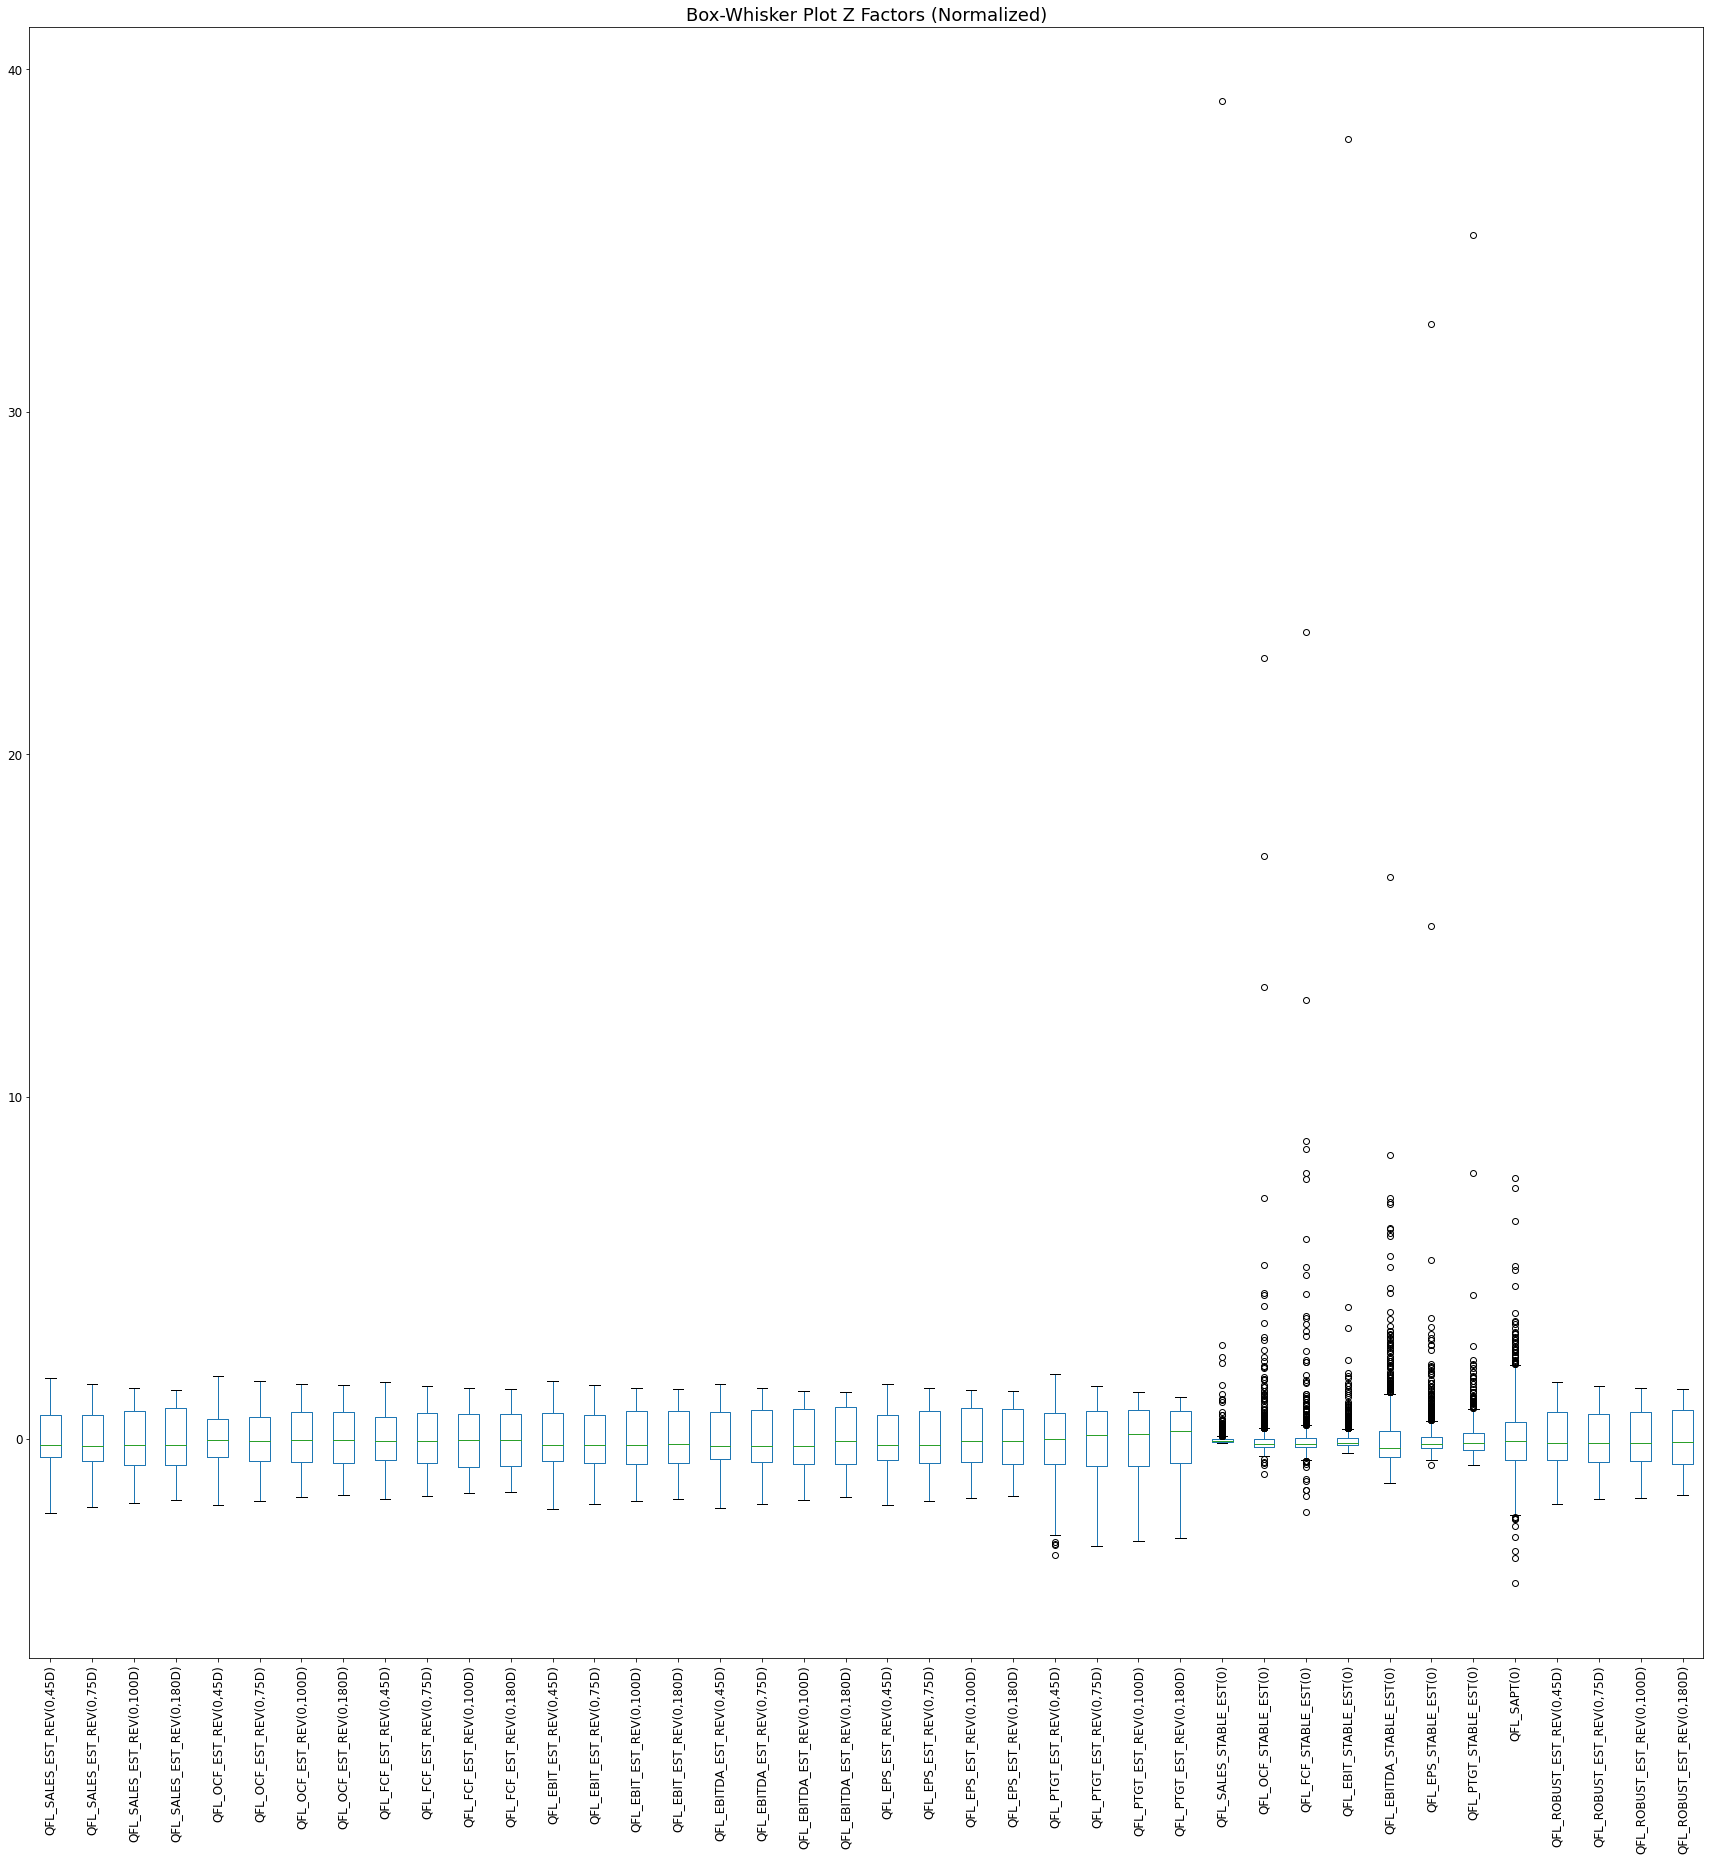

In [88]:
# Box-Whisker plot (Normalized data)

qfl_df_z.boxplot(grid=False, rot=90, fontsize=12, figsize = (30,30)).set_title('Box-Whisker Plot Z Factors (Normalized)', fontsize = 18);

In [89]:
# Greedy Multi-Factor Simple Average from all Multi-Factor's components

# MFR Z-Score

qfl_df_z['MFR'] = qfl_df_z.mean(axis = 1)

qfl_df_z.head()

,"QFL_SALES_EST_REV(0,45D)","QFL_SALES_EST_REV(0,75D)","QFL_SALES_EST_REV(0,100D)","QFL_SALES_EST_REV(0,180D)","QFL_OCF_EST_REV(0,45D)","QFL_OCF_EST_REV(0,75D)","QFL_OCF_EST_REV(0,100D)","QFL_OCF_EST_REV(0,180D)","QFL_FCF_EST_REV(0,45D)","QFL_FCF_EST_REV(0,75D)","QFL_FCF_EST_REV(0,100D)","QFL_FCF_EST_REV(0,180D)","QFL_EBIT_EST_REV(0,45D)","QFL_EBIT_EST_REV(0,75D)","QFL_EBIT_EST_REV(0,100D)","QFL_EBIT_EST_REV(0,180D)","QFL_EBITDA_EST_REV(0,45D)","QFL_EBITDA_EST_REV(0,75D)","QFL_EBITDA_EST_REV(0,100D)","QFL_EBITDA_EST_REV(0,180D)","QFL_EPS_EST_REV(0,45D)","QFL_EPS_EST_REV(0,75D)","QFL_EPS_EST_REV(0,100D)","QFL_EPS_EST_REV(0,180D)","QFL_PTGT_EST_REV(0,45D)","QFL_PTGT_EST_REV(0,75D)","QFL_PTGT_EST_REV(0,100D)","QFL_PTGT_EST_REV(0,180D)",QFL_SALES_STABLE_EST(0),QFL_OCF_STABLE_EST(0),QFL_FCF_STABLE_EST(0),QFL_EBIT_STABLE_EST(0),QFL_EBITDA_STABLE_EST(0),QFL_EPS_STABLE_EST(0),QFL_PTGT_STABLE_EST(0),QFL_SAPT(0),"QFL_ROBUST_EST_REV(0,45D)","QFL_ROBUST_EST_REV(0,75D)","QFL_ROBUST_EST_REV(0,100D)","QFL_ROBUST_EST_REV(0,180D)",MFR
0,-2.157,-1.980749,-1.877527,-1.773922,-1.921681,-1.802857,-1.690684,-1.62947,-1.76613,-1.66525,-1.583839,-1.543797,-2.046024,-1.909727,-1.820768,-1.753248,-2.023296,-1.897118,-1.787778,-1.707936,-1.942997,-1.80009,-1.736478,-1.674676,-3.384978,-3.116079,-2.969144,-2.892325,-0.106735,-1.014865,-2.120008,-0.401297,-1.295960,-0.746990,-0.751241,-4.219537,-1.901998,-1.764577,-1.714067,-1.648458,-1.838533
1,-2.157,-1.980749,-1.877527,-1.773922,-1.921681,-1.802857,-1.690684,-1.62947,-1.76613,-1.66525,-1.583839,-1.543797,-2.046024,-1.909727,-1.820768,-1.753248,-2.023296,-1.897118,-1.787778,-1.707936,-1.942997,-1.80009,-1.736478,-1.674676,-3.090918,-3.116079,-2.969144,-2.892325,-0.106254,-0.766336,-1.673193,-0.399613,-1.096348,-0.622038,-0.749495,-3.477976,-1.901998,-1.764577,-1.714067,-1.648458,-1.787047
2,-2.157,-1.980749,-1.877527,-1.773922,-1.921681,-1.802857,-1.690684,-1.62947,-1.76613,-1.66525,-1.583839,-1.543797,-2.046024,-1.909727,-1.820768,-1.753248,-2.023296,-1.897118,-1.787778,-1.707936,-1.942997,-1.80009,-1.736478,-1.674676,-3.054160,-3.116079,-2.969144,-2.892325,-0.105748,-0.709523,-1.500899,-0.364604,-1.071353,-0.605612,-0.718956,-3.270155,-1.901998,-1.764577,-1.714067,-1.648458,-1.772518
3,-2.157,-1.980749,-1.877527,-1.773922,-1.921681,-1.802857,-1.690684,-1.62947,-1.76613,-1.66525,-1.583839,-1.543797,-2.046024,-1.909727,-1.820768,-1.753248,-2.023296,-1.897118,-1.787778,-1.707936,-1.942997,-1.80009,-1.736478,-1.674676,-3.024086,-3.116079,-2.969144,-2.892325,-0.105729,-0.671519,-1.476854,-0.356791,-1.070378,-0.576446,-0.716072,-2.852333,-1.901998,-1.764577,-1.714067,-1.648458,-1.758748
4,-2.157,-1.980749,-1.877527,-1.773922,-1.921681,-1.802857,-1.690684,-1.62947,-1.76613,-1.66525,-1.583839,-1.543797,-2.046024,-1.909727,-1.820768,-1.753248,-2.023296,-1.897118,-1.787778,-1.707936,-1.942997,-1.80009,-1.736478,-1.674676,-2.817862,-2.949330,-2.969144,-2.892325,-0.105686,-0.598986,-1.227076,-0.354079,-1.041741,-0.563507,-0.692610,-2.535459,-1.901998,-1.764577,-1.714067,-1.648458,-1.731749


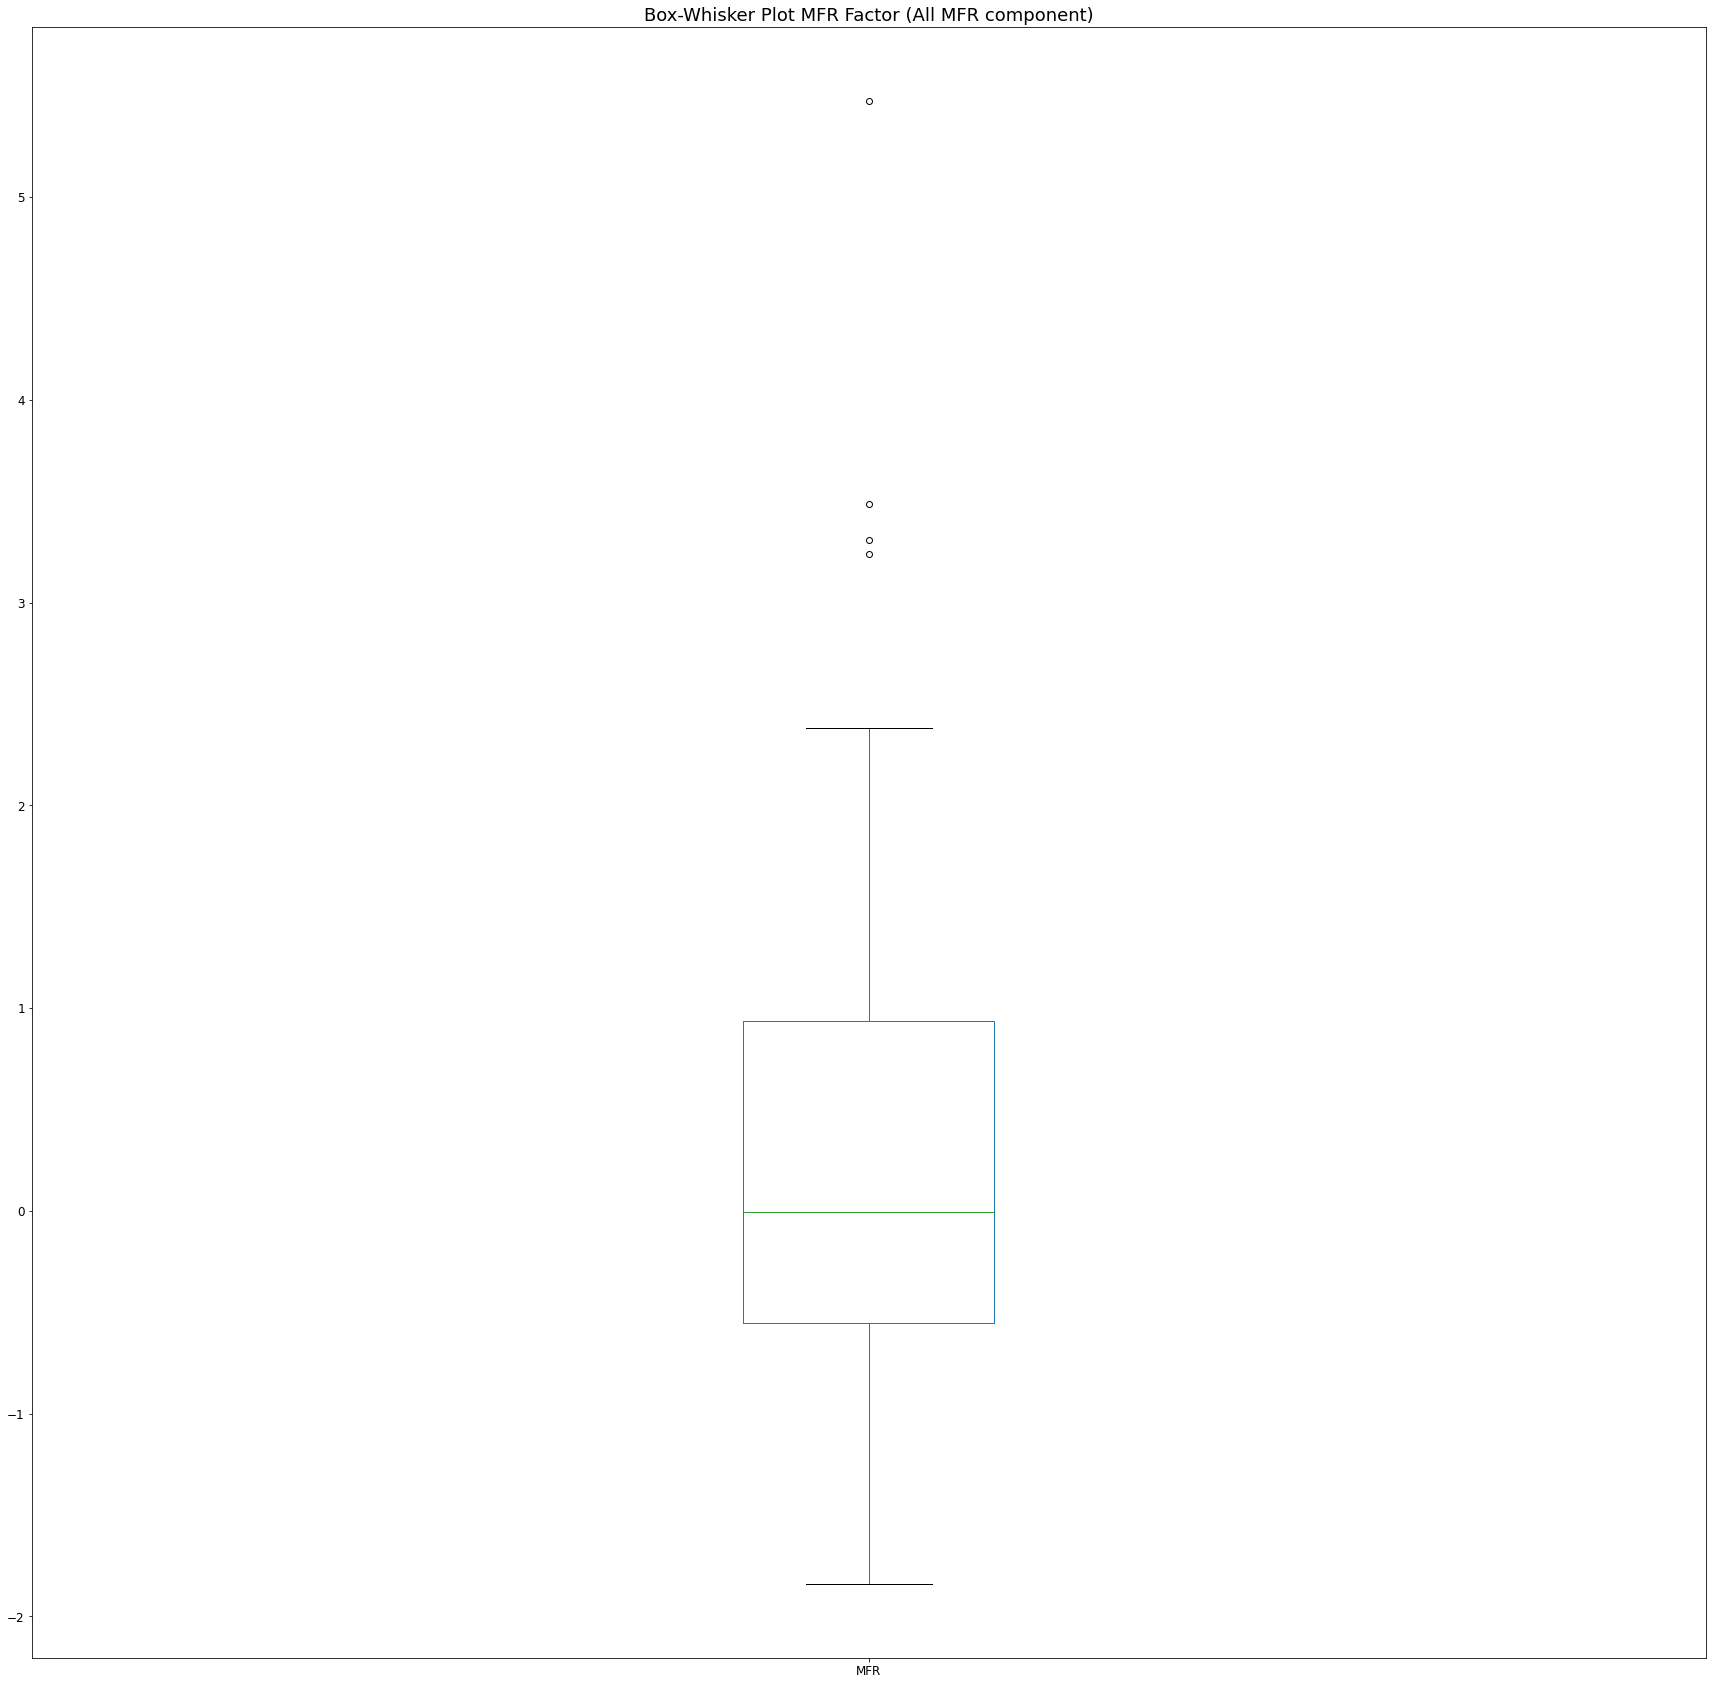

In [90]:
pd.DataFrame(qfl_df_z['MFR']).boxplot(grid=False, fontsize=12, figsize = (30,30)).set_title('Box-Whisker Plot MFR Factor (All MFR component)', fontsize = 18);

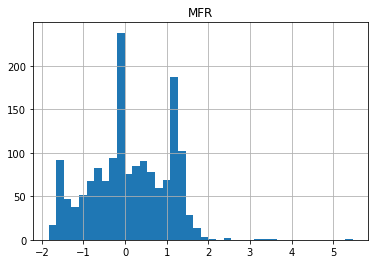

In [91]:
# MFR Distribution

pd.DataFrame(qfl_df_z['MFR']).hist(bins = int(np.sqrt(len(qfl_df_z['MFR']))));

In [92]:
# Check Infomation Coefficient: MFR (Components: All, Z-Scored Only)

sp_corr_z, sp_pval_z = stats.spearmanr(-qfl_df_z['MFR'].replace(np.nan, 0), qfl_df['p_total_return'].replace(np.nan, 0))
print('Information Coefficient: {0}'.format(round(sp_corr_z,2)))
print('Information Coefficient (P-Value): {0}'.format(round(sp_pval_z,2)))

Information Coefficient: 0.05
Information Coefficient (P-Value): 0.07


C:\Users\ffais\Anaconda3\lib\site-packages\pandas\core\series.py:726: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


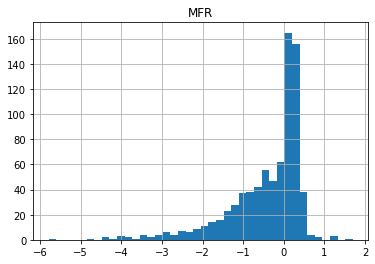

In [93]:
# MFR Log-Distribution

pd.DataFrame(np.log(qfl_df_z['MFR'])).hist(bins = int(np.sqrt(len(qfl_df_z['MFR']))));

In [94]:
# Log-Transformation for positive/not-zero features

qfl_df_log = pd.DataFrame()

for col_pos in qfl_df[qfl_df.columns[filter_idx]]:
    if np.sum(qfl_df[qfl_df.columns[filter_idx]][col_pos] <= 0) == 0:
        qfl_df_log[col_pos] = np.log(qfl_df[qfl_df.columns[filter_idx]][col_pos])
    else:
        qfl_df_log[col_pos] = qfl_df[qfl_df.columns[filter_idx]][col_pos]
    
qfl_df_log

,"QFL_SALES_EST_REV(0,45D)","QFL_SALES_EST_REV(0,75D)","QFL_SALES_EST_REV(0,100D)","QFL_SALES_EST_REV(0,180D)","QFL_OCF_EST_REV(0,45D)","QFL_OCF_EST_REV(0,75D)","QFL_OCF_EST_REV(0,100D)","QFL_OCF_EST_REV(0,180D)","QFL_FCF_EST_REV(0,45D)","QFL_FCF_EST_REV(0,75D)","QFL_FCF_EST_REV(0,100D)","QFL_FCF_EST_REV(0,180D)","QFL_EBIT_EST_REV(0,45D)","QFL_EBIT_EST_REV(0,75D)","QFL_EBIT_EST_REV(0,100D)","QFL_EBIT_EST_REV(0,180D)","QFL_EBITDA_EST_REV(0,45D)","QFL_EBITDA_EST_REV(0,75D)","QFL_EBITDA_EST_REV(0,100D)","QFL_EBITDA_EST_REV(0,180D)","QFL_EPS_EST_REV(0,45D)","QFL_EPS_EST_REV(0,75D)","QFL_EPS_EST_REV(0,100D)","QFL_EPS_EST_REV(0,180D)","QFL_PTGT_EST_REV(0,45D)","QFL_PTGT_EST_REV(0,75D)","QFL_PTGT_EST_REV(0,100D)","QFL_PTGT_EST_REV(0,180D)",QFL_SALES_STABLE_EST(0),QFL_OCF_STABLE_EST(0),QFL_FCF_STABLE_EST(0),QFL_EBIT_STABLE_EST(0),QFL_EBITDA_STABLE_EST(0),QFL_EPS_STABLE_EST(0),QFL_PTGT_STABLE_EST(0),QFL_SAPT(0),"QFL_ROBUST_EST_REV(0,45D)","QFL_ROBUST_EST_REV(0,75D)","QFL_ROBUST_EST_REV(0,100D)","QFL_ROBUST_EST_REV(0,180D)"
0,20.00000,16.666668,26.666668,26.666668,-30.000002,-30.000002,-20.000000,-20.000000,-20.000000,-20.000000,-10.000000,0.000000,3.846154,3.846154,11.538462,15.384616,16.666668,16.666668,16.666668,33.333336,8.823529,8.823529,11.764706,11.764706,24.324326,43.243244,70.270270,86.486490,3.487577,4.564552,4.542493,19.244207,19.508547,19.488585,1.821437,0.368052,0.071429,0.071429,0.107143,0.107143
1,-25.00000,-25.000000,-25.000000,-41.666664,0.000000,0.000000,0.000000,0.000000,40.000000,50.000000,50.000000,50.000000,20.833332,25.000000,25.000000,33.333336,50.000000,50.000000,50.000000,50.000000,39.285713,39.285713,39.285713,50.000000,51.724136,65.517240,68.965515,86.206894,4.692379,4.214087,2.703884,31.855938,14.435187,30.917423,3.053941,2.594193,0.500000,0.500000,0.500000,0.500000
2,92.68293,92.682930,92.682930,92.682930,0.000000,0.000000,14.285715,14.285715,-22.222223,-22.222223,-22.222223,-22.222223,-74.285710,-71.428570,-71.428570,-74.285710,-61.290325,-61.290325,-61.290325,-58.064514,-74.418600,-74.418600,-74.418600,-74.418600,50.000000,56.521736,58.695650,86.956520,4.166526,3.658377,1.738355,4.552811,12.300735,4.968252,2.728973,2.648956,-0.677419,-0.677419,-0.677419,-0.645161
3,92.50000,92.500000,92.500000,92.500000,87.500000,87.500000,87.500000,87.500000,0.000000,0.000000,0.000000,0.000000,91.666670,91.666670,94.444440,94.444440,91.666670,91.666670,91.666670,91.666670,88.636360,88.636360,90.909096,93.181816,79.069770,83.720930,86.046510,93.023260,3.693017,7.576492,4.861445,14.970654,28.221222,13.357665,2.820335,2.464546,1.000000,1.000000,1.000000,1.000000
4,92.30769,92.307690,92.307690,92.307690,0.000000,0.000000,0.000000,0.000000,50.000000,50.000000,50.000000,50.000000,80.000000,80.000000,80.000000,76.666664,90.476190,90.476190,90.476190,90.476190,73.529410,76.470590,76.470590,73.529410,92.105260,92.105260,94.736850,94.736850,3.549451,21.309880,5.774197,9.747973,18.677095,9.354807,2.565088,1.099191,0.904762,0.904762,0.904762,0.904762
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1595,-50.00000,0.000000,0.000000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,66.666670,33.333336,33.333336,33.333336,0.000000,-100.000000,-100.000000,-100.000000,75.000000,75.000000,75.000000,62.500000,3.603724,NaN,NaN,NaN,8.440292,NaN,1.641894,0.502705,0.000000,0.000000,0.000000,0.000000
1596,50.00000,50.000000,50.000000,50.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,-100.000000,-100.000000,NaN,NaN,NaN,NaN,100.000000,100.000000,100.000000,100.000000,-25.000000,-25.000000,-75.000000,-75.000000,3.639788,NaN,NaN,NaN,NaN,25.502640,1.274214,0.585734,NaN,NaN,NaN,NaN
1597,0.00000,0.000000,0.000000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,-100.000000,-100.000000,-100.000000,0.000000,0.000000,0.000000,0.000000,4.532986,NaN,NaN,NaN,35.904945,NaN,1.5

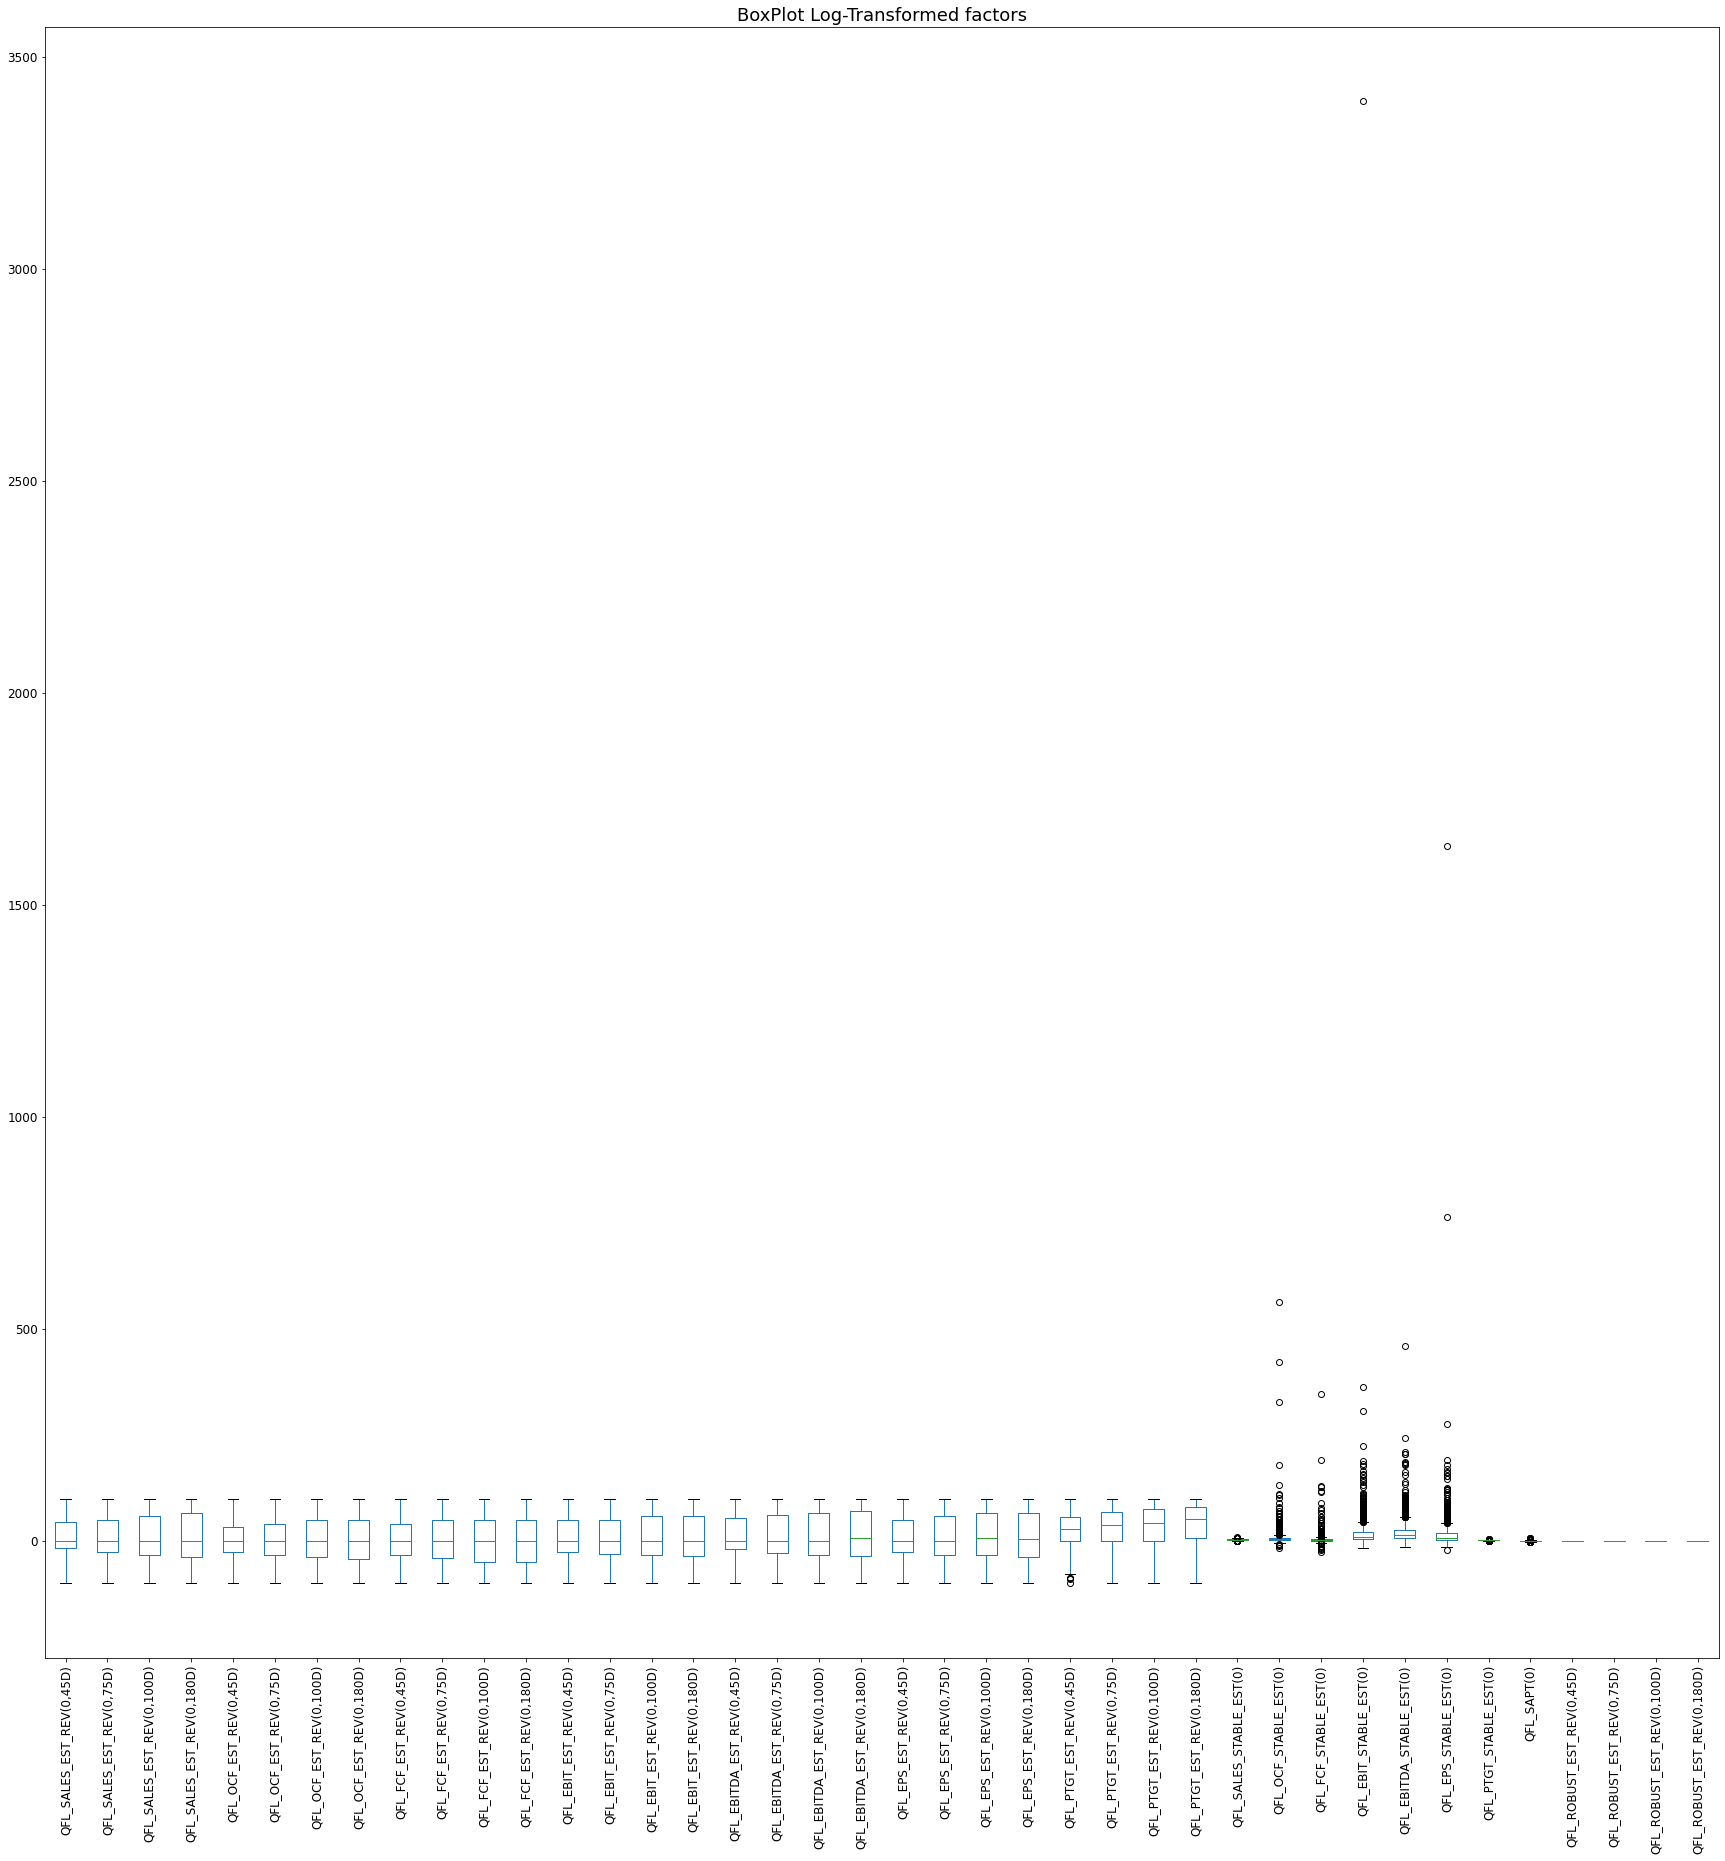

In [95]:
# Box-Whisker plot of Log-Transformed data

qfl_df_log.boxplot(grid=False, rot=90, fontsize=12, figsize = (30,30)).set_title('BoxPlot Log-Transformed factors', fontsize = 18);

In [96]:
# MFR Z-Score of Log-Transformed and Z-Scored data

# Z-Score of Log-Transformed data

qfl_df_log_z = pd.DataFrame()

for factor in qfl_df_log:
    z_score = ( qfl_df_log[factor] - qfl_df_log[factor].mean() ) / qfl_df_log[factor].std()
    qfl_df_log_z[factor] = z_score

qfl_df_log_z['MFR'] = qfl_df_log_z.mean(axis = 1)

qfl_df_log_z.head()

,"QFL_SALES_EST_REV(0,45D)","QFL_SALES_EST_REV(0,75D)","QFL_SALES_EST_REV(0,100D)","QFL_SALES_EST_REV(0,180D)","QFL_OCF_EST_REV(0,45D)","QFL_OCF_EST_REV(0,75D)","QFL_OCF_EST_REV(0,100D)","QFL_OCF_EST_REV(0,180D)","QFL_FCF_EST_REV(0,45D)","QFL_FCF_EST_REV(0,75D)","QFL_FCF_EST_REV(0,100D)","QFL_FCF_EST_REV(0,180D)","QFL_EBIT_EST_REV(0,45D)","QFL_EBIT_EST_REV(0,75D)","QFL_EBIT_EST_REV(0,100D)","QFL_EBIT_EST_REV(0,180D)","QFL_EBITDA_EST_REV(0,45D)","QFL_EBITDA_EST_REV(0,75D)","QFL_EBITDA_EST_REV(0,100D)","QFL_EBITDA_EST_REV(0,180D)","QFL_EPS_EST_REV(0,45D)","QFL_EPS_EST_REV(0,75D)","QFL_EPS_EST_REV(0,100D)","QFL_EPS_EST_REV(0,180D)","QFL_PTGT_EST_REV(0,45D)","QFL_PTGT_EST_REV(0,75D)","QFL_PTGT_EST_REV(0,100D)","QFL_PTGT_EST_REV(0,180D)",QFL_SALES_STABLE_EST(0),QFL_OCF_STABLE_EST(0),QFL_FCF_STABLE_EST(0),QFL_EBIT_STABLE_EST(0),QFL_EBITDA_STABLE_EST(0),QFL_EPS_STABLE_EST(0),QFL_PTGT_STABLE_EST(0),QFL_SAPT(0),"QFL_ROBUST_EST_REV(0,45D)","QFL_ROBUST_EST_REV(0,75D)","QFL_ROBUST_EST_REV(0,100D)","QFL_ROBUST_EST_REV(0,180D)",MFR
0,0.211205,0.102677,0.260151,0.261777,-0.607186,-0.580289,-0.369442,-0.348160,-0.395134,-0.378495,-0.196577,-0.036561,-0.101212,-0.105154,0.022635,0.099545,0.091035,0.073714,0.070899,0.335736,-0.016470,-0.018488,0.025718,0.036175,-0.094683,0.227918,0.737410,0.944516,0.112784,-0.121440,0.028726,0.010057,-0.054709,0.067558,-0.446668,-0.172143,0.014016,0.008133,0.057744,0.070417,-0.004307
1,-0.676872,-0.641404,-0.611797,-0.836429,-0.043831,-0.056331,-0.039131,-0.027833,0.633113,0.747417,0.728264,0.717057,0.216921,0.262445,0.245114,0.387757,0.695130,0.636809,0.601949,0.591195,0.522809,0.480223,0.459642,0.621466,0.630464,0.747902,0.709007,0.938763,1.159076,-0.135840,-0.097430,0.151787,-0.244345,0.296719,2.143148,2.190746,0.780421,0.717216,0.686451,0.680341,0.424203
2,1.645606,1.460170,1.374268,1.322744,-0.043831,-0.056331,0.196805,0.200972,-0.433217,-0.414238,-0.384971,-0.371502,-1.564451,-1.413230,-1.348566,-1.340340,-1.321767,-1.243202,-1.171074,-1.065168,-1.490124,-1.381285,-1.333136,-1.283086,0.584834,0.537903,0.485446,0.954186,0.702407,-0.158673,-0.163680,-0.155044,-0.324128,-0.223592,1.460304,2.248873,-1.325134,-1.230858,-1.197826,-1.097560,-0.259037
3,1.641996,1.456904,1.371181,1.319804,1.599288,1.471879,1.405977,1.373599,-0.052385,-0.056806,-0.042437,-0.036561,1.543474,1.420936,1.392827,1.369051,1.450248,1.340678,1.265762,1.229843,1.396474,1.288166,1.273589,1.282477,1.354178,1.172865,1.080837,1.079005,0.291196,0.002313,0.050611,-0.037969,0.270960,-0.055374,1.652279,2.053135,1.674561,1.544481,1.486624,1.456607,1.069557
4,1.638201,1.453469,1.367936,1.316714,-0.043831,-0.056331,-0.039131,-0.027833,0.804488,0.747417,0.728264,0.717057,1.324983,1.218200,1.154103,1.083583,1.428673,1.320568,1.246796,1.211596,1.129033,1.088994,1.045937,0.981645,1.699168,1.368596,1.270014,1.114261,0.166517,0.566585,0.113239,-0.096661,-0.085788,-0.135636,1.115938,0.603909,1.504249,1.386907,1.334210,1.308747,0.901870


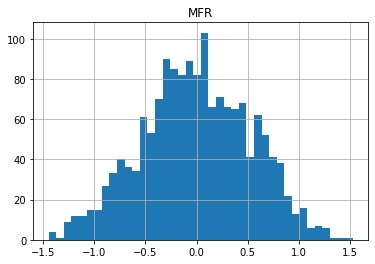

In [97]:
# MFR Distribution (of Log-Transformed and Z-Score factors)

pd.DataFrame(qfl_df_log_z['MFR']).hist(bins = int(np.sqrt(len(qfl_df_log_z['MFR']))));

In [98]:
# Check Infomation Coefficient: MRF (Components: All, Z-Scored & Log-Transformed)

sp_corr_z_log, sp_pval_z_log = stats.spearmanr(-qfl_df_log_z['MFR'].replace(np.nan, 0), qfl_df['p_total_return'].replace(np.nan, 0))
print('Information Coefficient: {0}'.format(round(sp_corr_z_log,2)))
print('Information Coefficient (P-Value): {0}'.format(round(sp_pval_z_log,2)))

Information Coefficient: -0.06
Information Coefficient (P-Value): 0.01


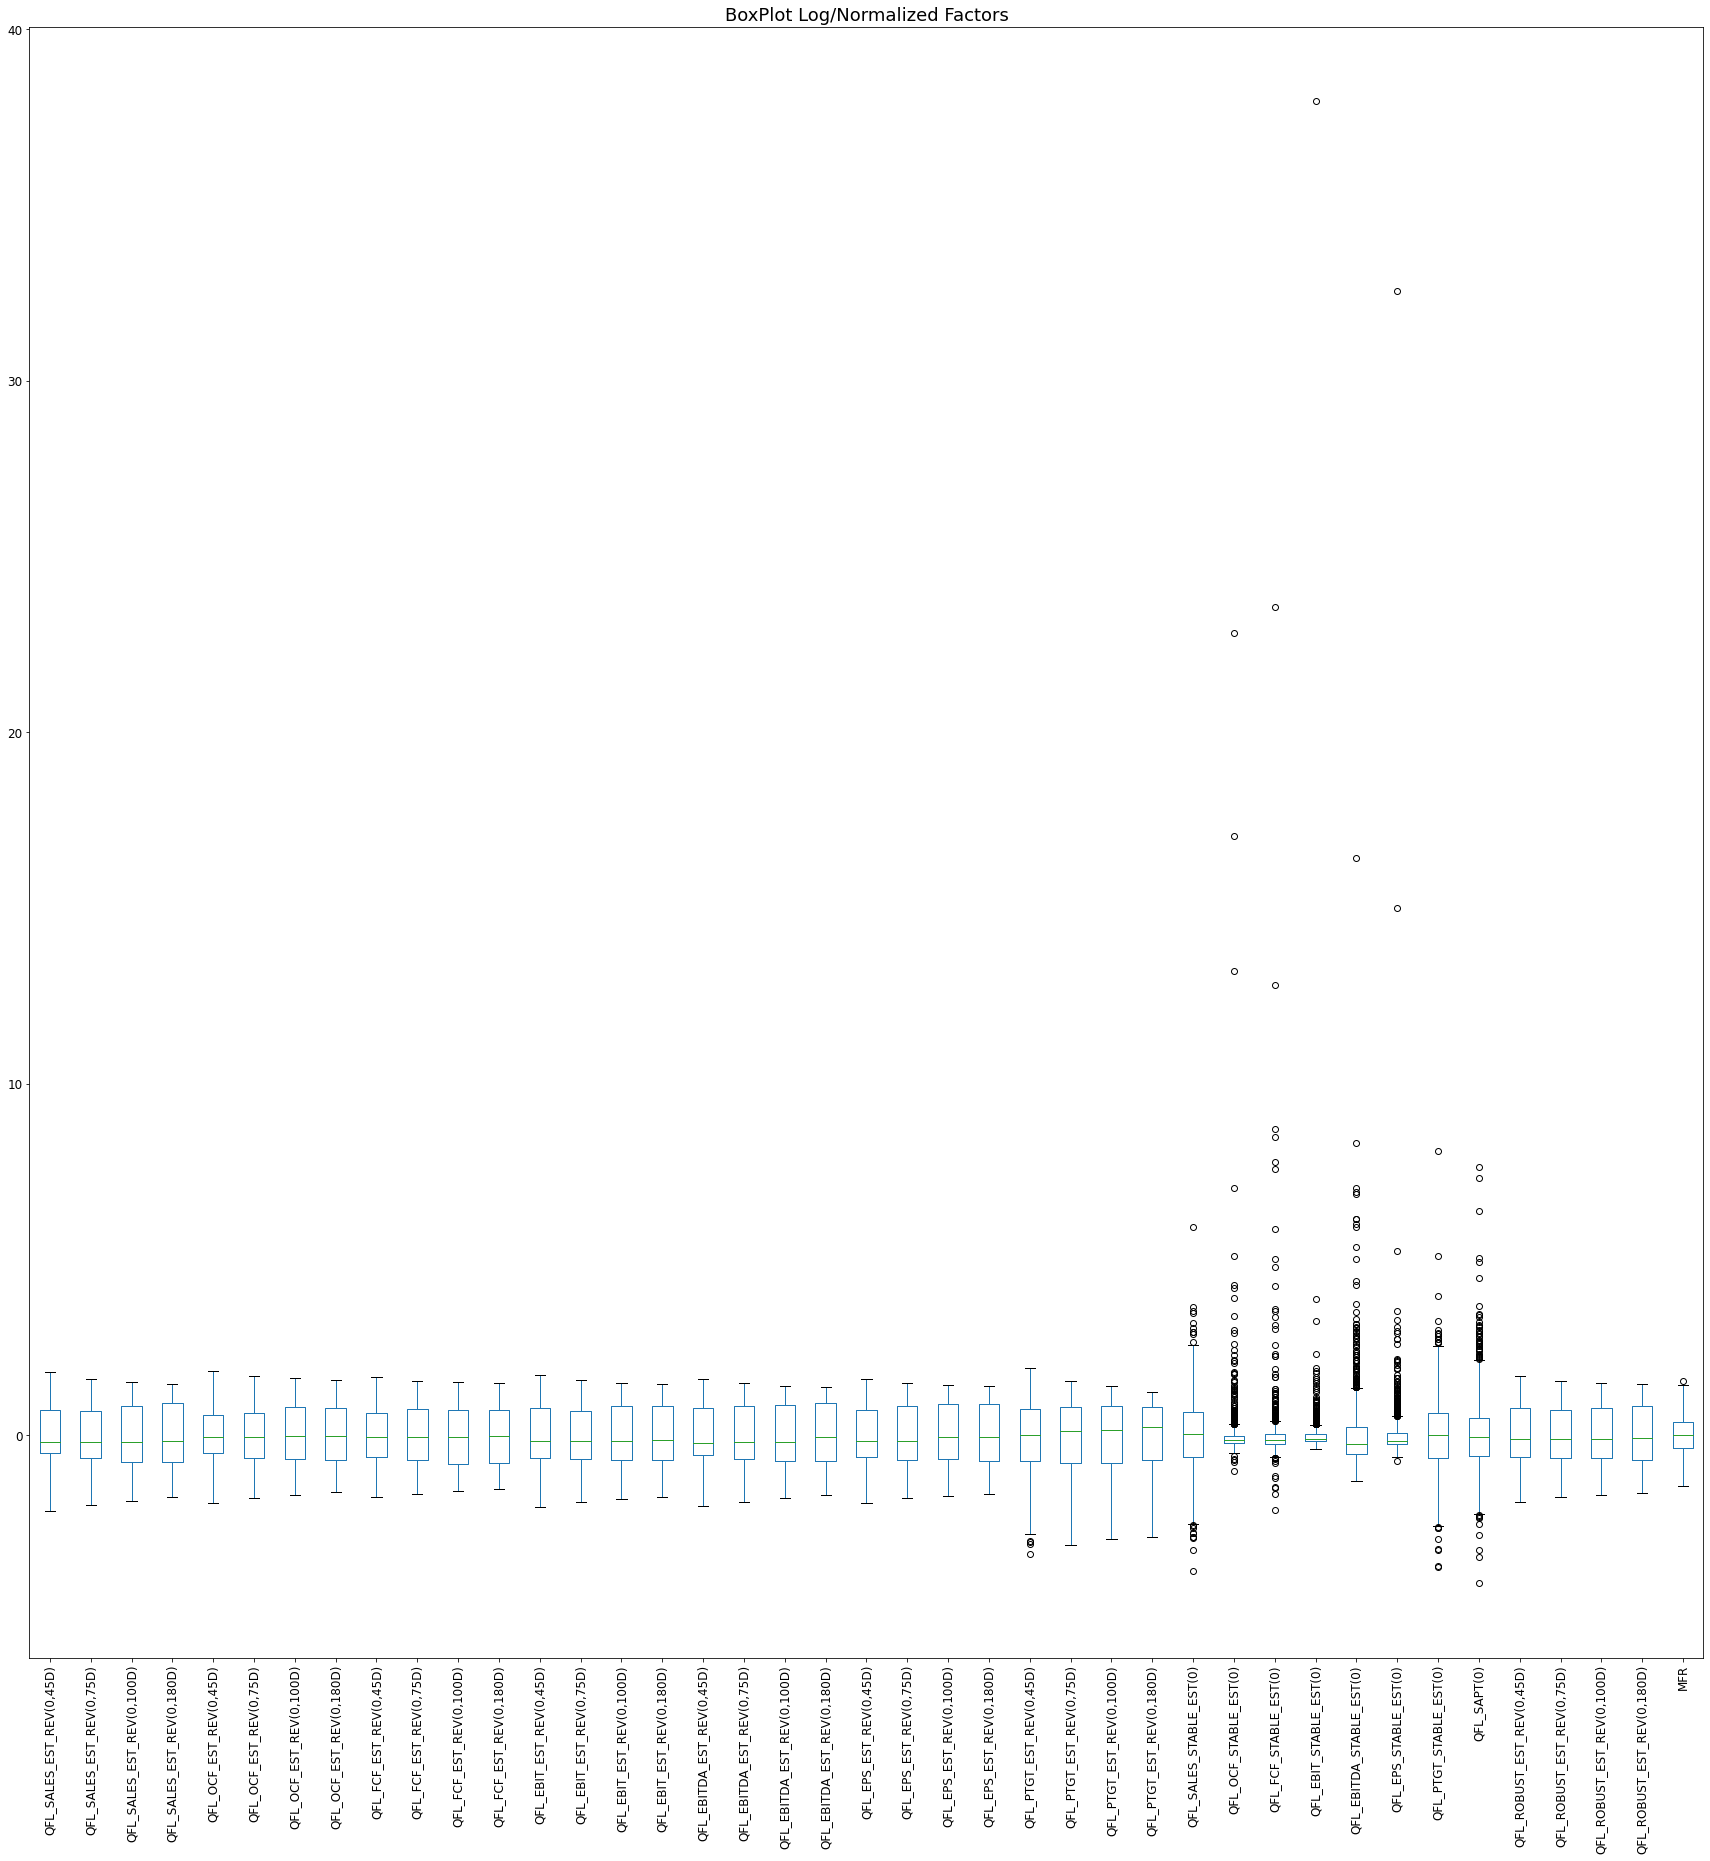

In [99]:
# Box-Whisker plot of Log-Transformed and Z-Score data

qfl_df_log_z.boxplot(grid=False, rot=90, fontsize=12, figsize = (30,30)).set_title('BoxPlot Log/Normalized Factors', fontsize = 18);

In [100]:
# Check Universe Exposures (Geography, Size, Sector)

qfl_df['ison_screen'] = 1

qfl_df.head()

,BENCHMARK_ID,DATE,SECURITY_ID,Weight,proper_name,fg_gics_sector,proper,p_total_return,qfl_size_class,qfl_mkt_val_sec,"QFL_SALES_EST_REV(0,45D)","QFL_SALES_EST_REV(0,75D)","QFL_SALES_EST_REV(0,100D)","QFL_SALES_EST_REV(0,180D)","QFL_OCF_EST_REV(0,45D)","QFL_OCF_EST_REV(0,75D)","QFL_OCF_EST_REV(0,100D)","QFL_OCF_EST_REV(0,180D)","QFL_FCF_EST_REV(0,45D)","QFL_FCF_EST_REV(0,75D)","QFL_FCF_EST_REV(0,100D)","QFL_FCF_EST_REV(0,180D)","QFL_EBIT_EST_REV(0,45D)","QFL_EBIT_EST_REV(0,75D)","QFL_EBIT_EST_REV(0,100D)","QFL_EBIT_EST_REV(0,180D)","QFL_EBITDA_EST_REV(0,45D)","QFL_EBITDA_EST_REV(0,75D)","QFL_EBITDA_EST_REV(0,100D)","QFL_EBITDA_EST_REV(0,180D)","QFL_EPS_EST_REV(0,45D)","QFL_EPS_EST_REV(0,75D)","QFL_EPS_EST_REV(0,100D)","QFL_EPS_EST_REV(0,180D)","QFL_PTGT_EST_REV(0,45D)","QFL_PTGT_EST_REV(0,75D)","QFL_PTGT_EST_REV(0,100D)","QFL_PTGT_EST_REV(0,180D)",QFL_SALES_STABLE_EST(0),QFL_OCF_STABLE_EST(0),QFL_FCF_STABLE_EST(0),QFL_EBIT_STABLE_EST(0),QFL_EBITDA_STABLE_EST(0),QFL_EPS_STABLE_EST(0),QFL_PTGT_STABLE_EST(0),QFL_SAPT(0),"QFL_ROBUST_EST_REV(0,45D)","QFL_ROBUST_EST_REV(0,75D)","QFL_ROBUST_EST_REV(0,100D)","QFL_ROBUST_EST_REV(0,180D)",QFL_ROBUST_EST_ITEM(0),ison_screen
0,890100,30-Nov-2020,03783310,4.204100,Apple Inc.,Information Technology,United States,11.457372,Mega Cap,2024064.4,20.00000,16.666668,26.666668,26.666668,-30.000002,-30.000002,-20.000000,-20.000000,-20.000000,-20.000000,-10.000000,0.000000,3.846154,3.846154,11.538462,15.384616,16.666668,16.666668,16.666668,33.333336,8.823529,8.823529,11.764706,11.764706,24.324326,43.243244,70.270270,86.486490,32.706590,4.564552,4.542493,19.244207,19.508547,19.488585,6.180736,0.368052,0.071429,0.071429,0.107143,0.107143,NET_INC,1
1,890100,30-Nov-2020,59491810,3.141281,Microsoft Corporation,Information Technology,United States,3.900588,Mega Cap,1618475.4,-25.00000,-25.000000,-25.000000,-41.666664,0.000000,0.000000,0.000000,0.000000,40.000000,50.000000,50.000000,50.000000,20.833332,25.000000,25.000000,33.333336,50.000000,50.000000,50.000000,50.000000,39.285713,39.285713,39.285713,50.000000,51.724136,65.517240,68.965515,86.206894,109.112440,4.214087,2.703884,31.855938,14.435187,30.917423,21.198725,2.594193,0.500000,0.500000,0.500000,0.500000,EBITDA,1
2,890100,30-Nov-2020,02313510,2.735749,"Amazon.com, Inc.",Consumer Discretionary,United States,2.805829,Mega Cap,1589567.8,92.68293,92.682930,92.682930,92.682930,0.000000,0.000000,14.285715,14.285715,-22.222223,-22.222223,-22.222223,-22.222223,-74.285710,-71.428570,-71.428570,-74.285710,-61.290325,-61.290325,-61.290325,-58.064514,-74.418600,-74.418600,-74.418600,-74.418600,50.000000,56.521736,58.695650,86.956520,64.491000,3.658377,1.738355,4.552811,12.300735,4.968252,15.317146,2.648956,-0.677419,-0.677419,-0.677419,-0.645161,EBITDA_ADJ,1
3,890100,30-Nov-2020,30303M10,1.356526,"Facebook, Inc. Class A",Communication Services,United States,-1.375598,Mega Cap,665827.3,92.50000,92.500000,92.500000,92.500000,87.500000,87.500000,87.500000,87.500000,0.000000,0.000000,0.000000,0.000000,91.666670,91.666670,94.444440,94.444440,91.666670,91.666670,91.666670,91.666670,88.636360,88.636360,90.909096,93.181816,79.069770,83.720930,86.046510,93.023260,40.165850,7.576492,4.861445,14.970654,28.221222,13.357665,16.782465,2.464546,1.000000,1.000000,1.000000,1.000000,BPS,1
4,890100,30-Nov-2020,02079K10,1.085045,Alphabet Inc. Class C,Communication Services,United States,-0.503194,Mega Cap,580810.4,92.30769,92.307690,92.307690,92.307690,0.000000,0.000000,0.000000,0.000000,50.000000,50.000000,50.000000,50.000000,80.000000,80.000000,80.000000,76.666664,90.476190,90.476190,90.476190,90.476190,73.529410,76.470590,76.470590,73.529410,92.105260,92.105260,94.736850,94.736850,34.794197,21.309880,5.774197,9.747973,18.677095,9.354807,13.001797,1.099191,0.904762,0.904762,0.904762,0.904762,EBITDA,1


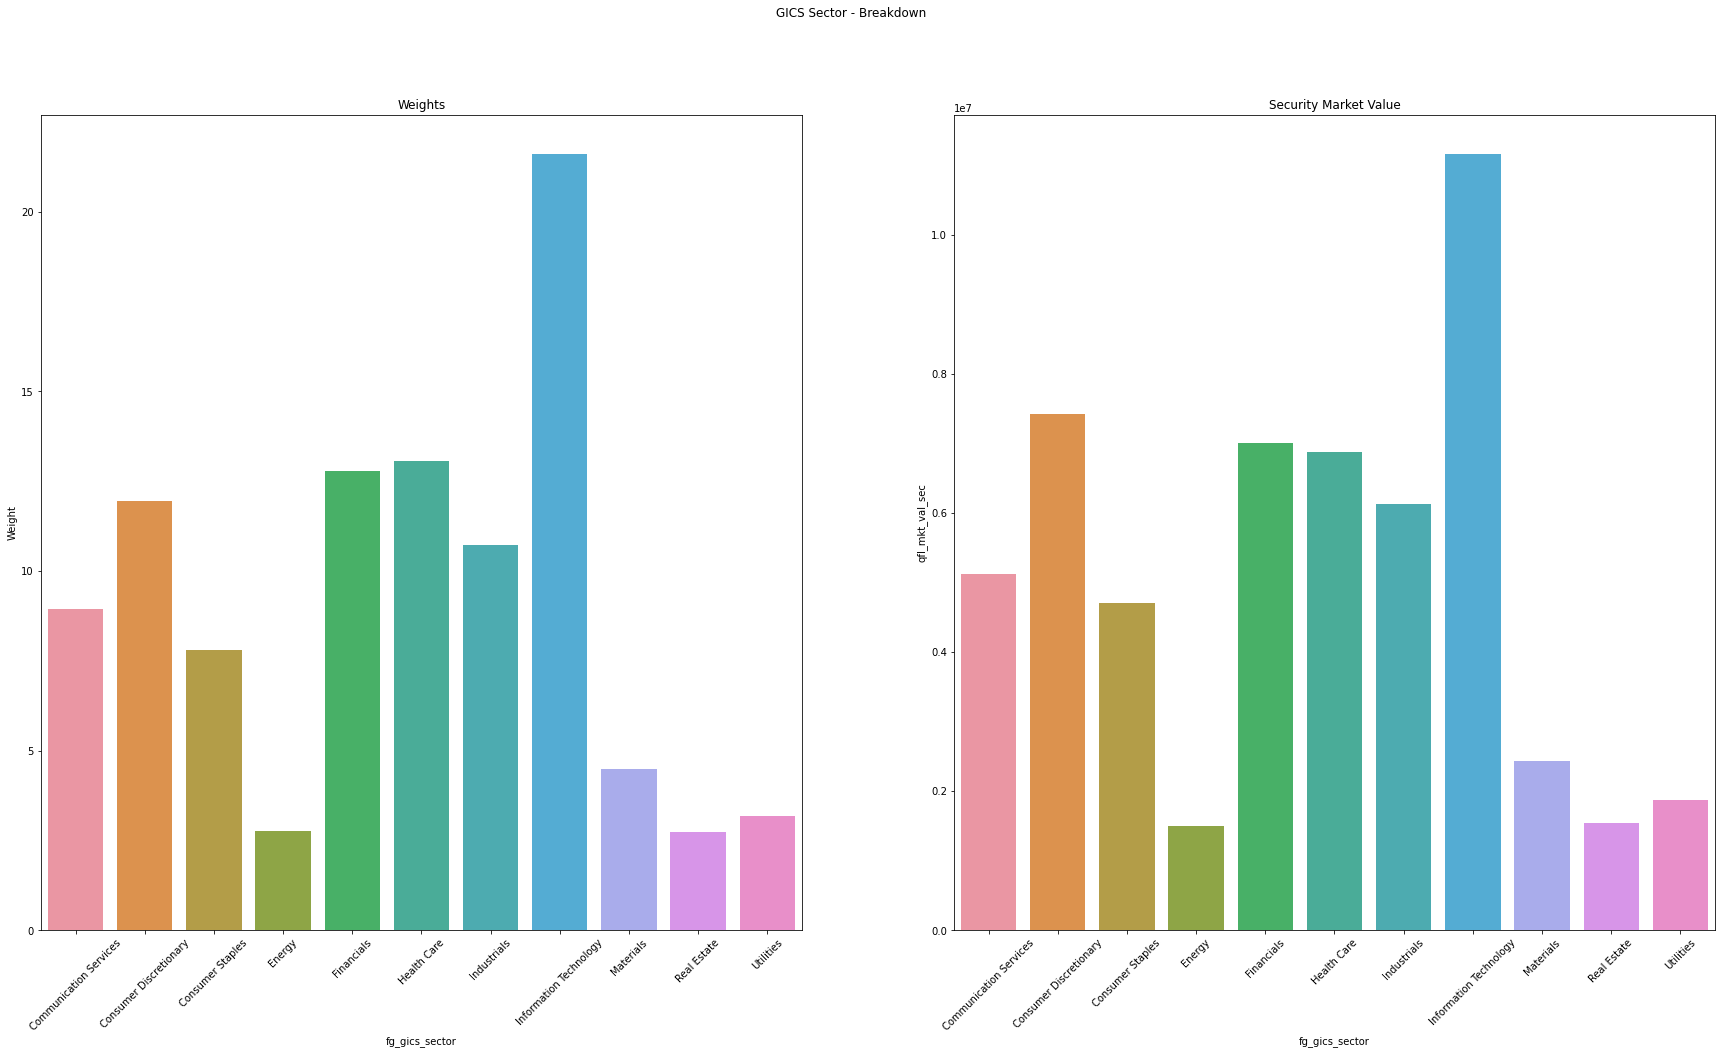

In [101]:
# Group universe

# GICS Sector
GICS_grouped = qfl_df.groupby('fg_gics_sector').sum()

fig, axes = plt.subplots(1, 2, figsize=(30, 15))
fig.suptitle('GICS Sector - Breakdown')
axes[0].set_title('Weights')
axes[1].set_title('Security Market Value')

chart = sns.barplot(ax=axes[0], x = GICS_grouped.index, y = 'Weight', data = GICS_grouped)
chart.set_xticklabels(chart.get_xticklabels(), rotation=45)
chart = sns.barplot(ax=axes[1], x = GICS_grouped.index, y = 'qfl_mkt_val_sec', data = GICS_grouped)
chart.set_xticklabels(chart.get_xticklabels(), rotation=45);

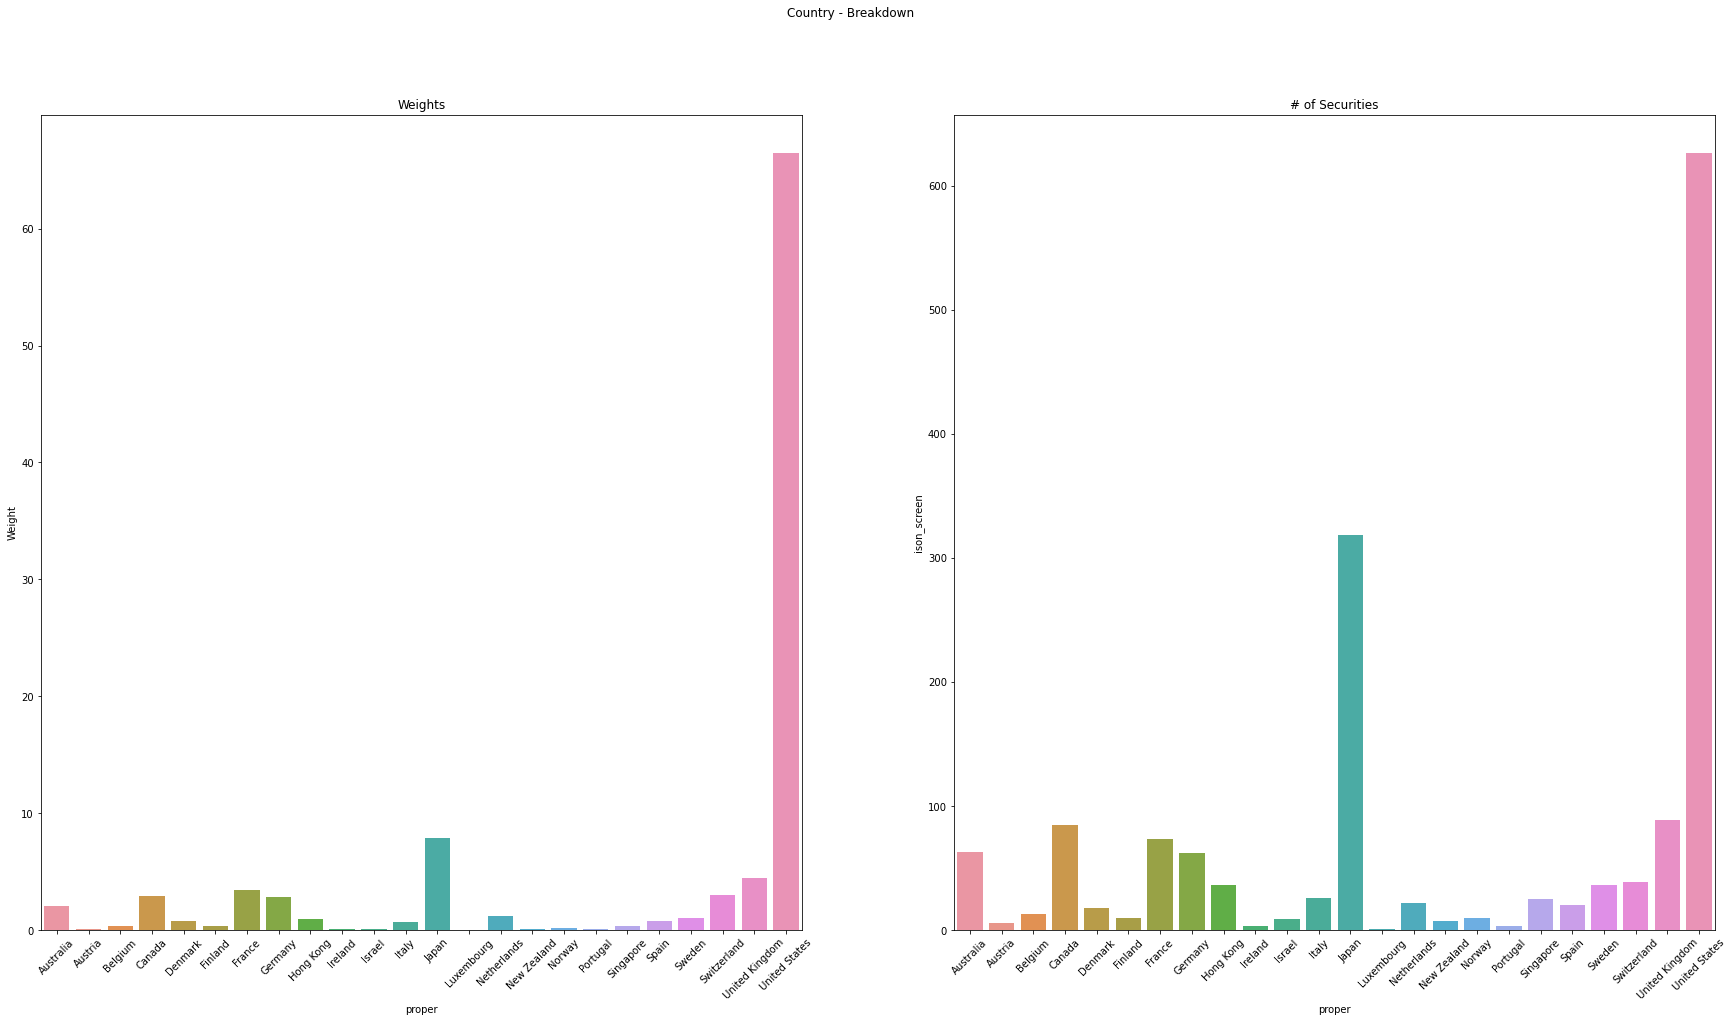

In [102]:
# Group universe

# Country
Country_grouped = qfl_df.groupby('proper').sum()

fig, axes = plt.subplots(1, 2, figsize=(30, 15))
fig.suptitle('Country - Breakdown')
axes[0].set_title('Weights')
axes[1].set_title('# of Securities')

chart = sns.barplot(ax=axes[0], x = Country_grouped.index, y = 'Weight', data = Country_grouped)
chart.set_xticklabels(chart.get_xticklabels(), rotation=45)
chart = sns.barplot(ax=axes[1], x = Country_grouped.index, y = 'ison_screen', data = Country_grouped)
chart.set_xticklabels(chart.get_xticklabels(), rotation=45);

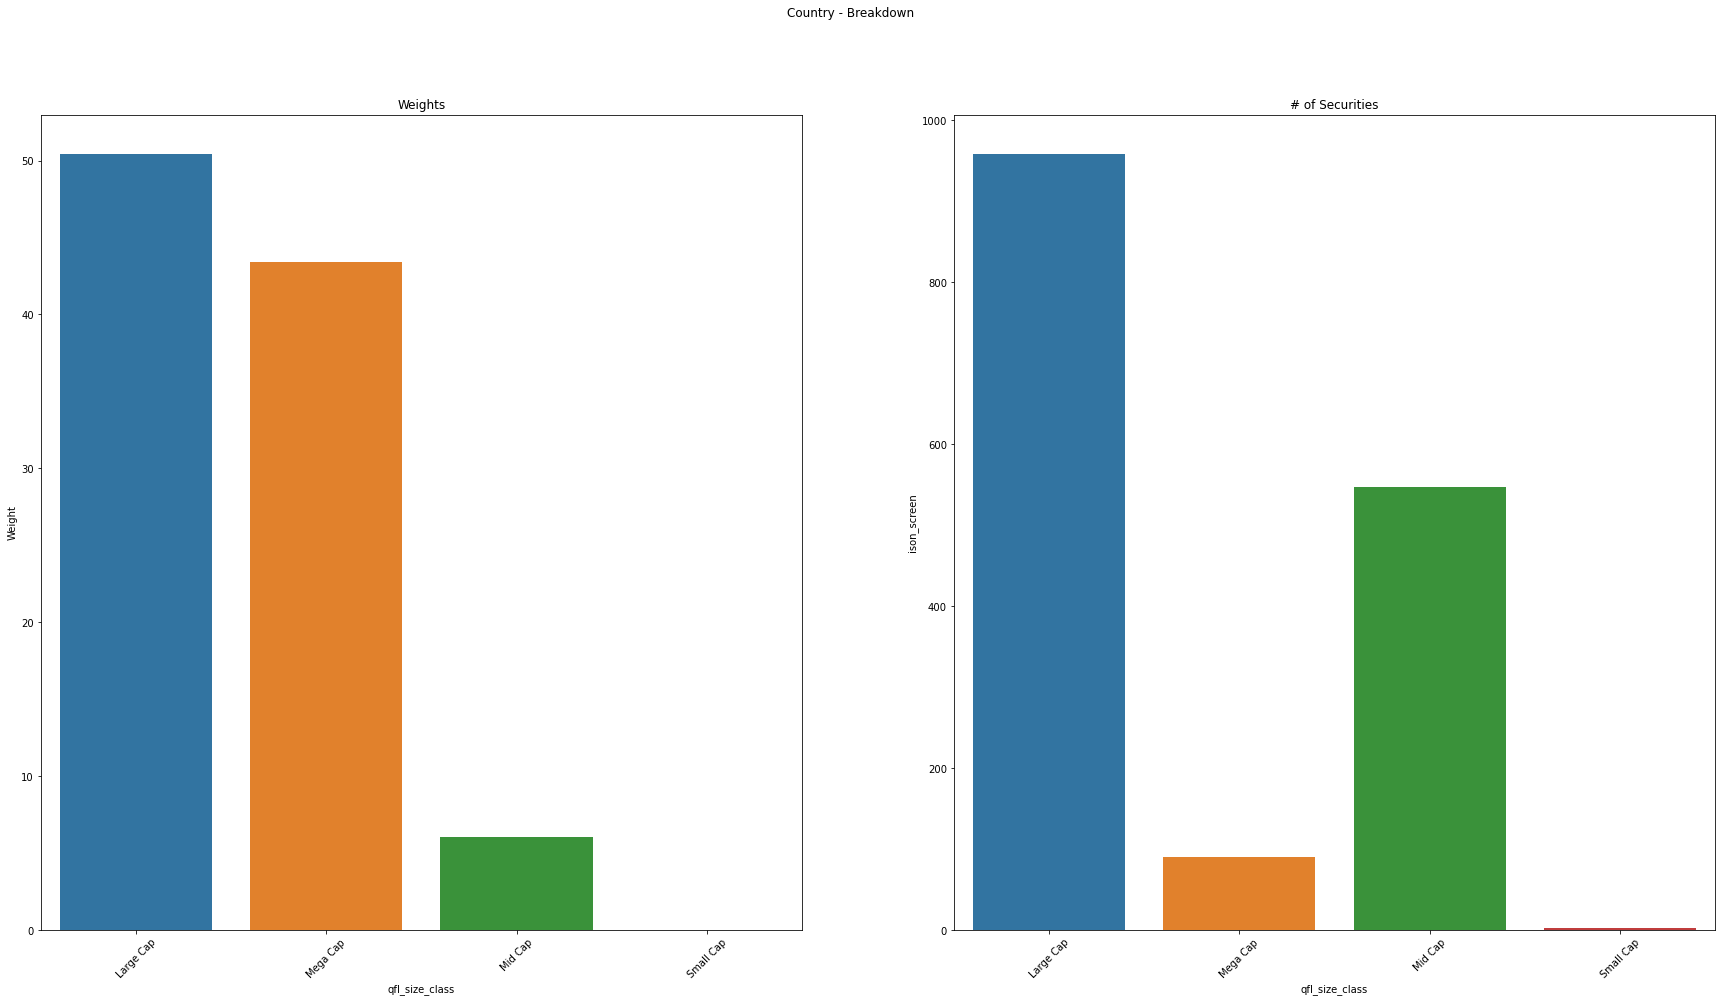

In [103]:
# Group universe

# Size
Size_grouped = qfl_df.groupby('qfl_size_class').sum()

fig, axes = plt.subplots(1, 2, figsize=(30, 15))
fig.suptitle('Country - Breakdown')
axes[0].set_title('Weights')
axes[1].set_title('# of Securities')

chart = sns.barplot(ax=axes[0], x = Size_grouped.index, y = 'Weight', data = Size_grouped)
chart.set_xticklabels(chart.get_xticklabels(), rotation=45)
chart = sns.barplot(ax=axes[1], x = Size_grouped.index, y = 'ison_screen', data = Size_grouped)
chart.set_xticklabels(chart.get_xticklabels(), rotation=45);

In [104]:
# Feature Selection

In [105]:
# Discard features with more than 80 NAs

qfl_filtered = qfl_df[qfl_df[qfl_df.columns[filter_idx]].isna().sum(axis = 0)[qfl_df[qfl_df.columns[filter_idx]].isna().sum(axis = 0) < 80].index]

In [106]:
# Replace NAs for retained features with feature's average

for col in qfl_filtered.columns:
    qfl_filtered[col] = qfl_filtered[col].replace(np.nan, qfl_filtered[col].mean(axis = 0))
    
qfl_df['p_total_return'] = qfl_df['p_total_return'].replace(np.nan, 0);

<ipython-input-106-d861f91d7765>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  qfl_filtered[col] = qfl_filtered[col].replace(np.nan, qfl_filtered[col].mean(axis = 0))


In [107]:
from sklearn.feature_selection import RFE
from sklearn.feature_selection import RFECV
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso

X = qfl_filtered
Y = qfl_df['p_total_return']

#RECURSIVE FEATURE ELIMINATION

lin_reg = Lasso()
rfe = RFE(lin_reg, n_features_to_select=3, step = 1)
fit_rfe = rfe.fit(X, Y)
print("Num Features: %s" % (fit_rfe.n_features_))
print("Selected Features: %s" % (fit_rfe.support_))
print("Feature Ranking: %s" % (fit_rfe.ranking_))


Num Features: 3
Selected Features: [False False False False False False False False False  True  True False
 False False False False False False False  True False]
Feature Ranking: [ 3 17  2 16 14  8 13  5 18  1  1 15 12 11 10  6  9  7  4  1 19]


In [108]:
qfl_filtered.columns[fit_rfe.support_]

Index(['QFL_EPS_EST_REV(0,75D)', 'QFL_EPS_EST_REV(0,100D)',
       'QFL_PTGT_STABLE_EST(0)'],
      dtype='object')

In [109]:
qfl_filtered[qfl_filtered.columns[fit_rfe.support_]].corr()

,"QFL_EPS_EST_REV(0,75D)","QFL_EPS_EST_REV(0,100D)",QFL_PTGT_STABLE_EST(0)
"QFL_EPS_EST_REV(0,75D)",1.000000,0.967116,0.027668
"QFL_EPS_EST_REV(0,100D)",0.967116,1.000000,0.032548
QFL_PTGT_STABLE_EST(0),0.027668,0.032548,1.000000


In [110]:
qfl_filtered[qfl_filtered.columns[fit_rfe.support_]]

,"QFL_EPS_EST_REV(0,75D)","QFL_EPS_EST_REV(0,100D)",QFL_PTGT_STABLE_EST(0)
0,8.823529,11.764706,6.180736
1,39.285713,39.285713,21.198725
2,-74.418600,-74.418600,15.317146
3,88.636360,90.909096,16.782465
4,76.470590,76.470590,13.001797
...,...,...,...
1595,-100.000000,-100.000000,5.164942
1596,100.000000,100.000000,3.575890
1597,-100.000000,-100.000000,4.569120
1598,33.333336,33.333336,3.564689


In [111]:
# MFR Z-Score after Feature Selection

qfl_mfr_RFE = pd.DataFrame()

for factor in qfl_filtered[qfl_filtered.columns[fit_rfe.support_]]:
    z_score_RFE = ( qfl_filtered[factor] - qfl_filtered[factor].mean() ) / qfl_filtered[factor].std()
    qfl_mfr_RFE[factor] = z_score_RFE

qfl_mfr_RFE['MFR'] = qfl_mfr_RFE.mean(axis = 1)

qfl_mfr_RFE.head()

,"QFL_EPS_EST_REV(0,75D)","QFL_EPS_EST_REV(0,100D)",QFL_PTGT_STABLE_EST(0),MFR
0,-0.018523,0.025766,-0.259280,-0.084012
1,0.481126,0.460507,1.258217,0.733283
2,-1.383883,-1.335644,0.663911,-0.685205
3,1.290589,1.275985,0.811975,1.126183
4,1.091043,1.047905,0.429956,0.856301


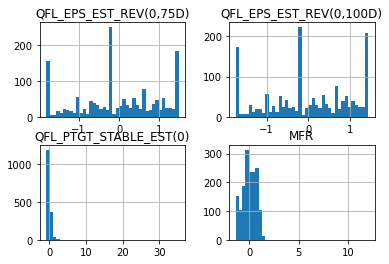

In [112]:
qfl_mfr_RFE.hist(bins = int(np.sqrt(len(qfl_mfr_RFE['MFR']))));

In [113]:
# Check Infomation Coefficient: MFR (Components: RFE's Feature Selected, Z-Scored)

sp_corr_z_rfe, sp_pval_z_rfe = stats.spearmanr(-qfl_mfr_RFE['MFR'].replace(np.nan, 0), qfl_df['p_total_return'].replace(np.nan, 0))
print('Information Coefficient: {0}'.format(round(sp_corr_z_rfe,2)))
print('Information Coefficient (P-Value): {0}'.format(round(sp_pval_z_rfe,2)))

Information Coefficient: -0.06
Information Coefficient (P-Value): 0.01


# Information Coefficient Summary (LVRB)

### Feature Selection: Recoursive Feature Elimination (RFE + Lasso) (3 Top Components)

In [114]:
print('Information Coefficient: {0}'.format(round(sp_corr_z_rfe,2)))
print('Information Coefficient (P-Value): {0}'.format(round(sp_pval_z_rfe,2)))

Information Coefficient: -0.06
Information Coefficient (P-Value): 0.01


### Z-Score + Log-Transformation (All Components)

In [115]:
print('Information Coefficient: {0}'.format(round(sp_corr_z_log,2)))
print('Information Coefficient (P-Value): {0}'.format(round(sp_pval_z_log,2)))

Information Coefficient: -0.06
Information Coefficient (P-Value): 0.01


### Z-Score Only (All Components)

In [116]:
print('Information Coefficient: {0}'.format(round(sp_corr_z,2)))
print('Information Coefficient (P-Value): {0}'.format(round(sp_pval_z,2)))

Information Coefficient: 0.05
Information Coefficient (P-Value): 0.07
